<a href="https://colab.research.google.com/github/hASEEBjAN/TensorFlow_Random_Programs/blob/master/COVID_19_Detection_from_Cough_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -r /content/sample_data

In [ ]:
!cp -r /content/drive/MyDrive/Safe\ City/COVID\ DETECTION\ USING\ COUGH/custom_dataset/custom_dataset /content/

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Input, concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
from tensorflow.keras.applications.vgg19 import VGG19
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import pylab
import cv2
import os
import io
import scipy.io

In [ ]:
!git clone https://github.com/iiscleap/Coswara-Data.git

In [ ]:
rt_dir = '/content/Coswara-Data'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

In [ ]:
!wget https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip
!mkdir 'custom_dataset'

--2021-01-14 05:17:15--  https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951442487 (907M) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>] 907.37M  16.5MB/s    in 54s     

2021-01-14 05:18:09 (16.9 MB/s) - ‘public_dataset.zip?download=1’ saved [951442487/951442487]

mkdir: cannot create directory ‘custom_dataset’: File exists


In [ ]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/content/Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData=pd.concat(df_list)
CosData['DataSet'] = 'coswara'
CosData.head()

In [ ]:
coughvid  = '/content/public_dataset/'
custpath  = '/content/custom_dataset/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19'][0:1000]

TotData   = pd.concat([extradata,notradata],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()

In [ ]:
!cp -r /content/drive/MyDrive/Safe\ City/COVID\ DETECTION\ USING\ COUGH/data.mat.npy /content/
saveddata = scipy.load('data.mat.npy', allow_pickle=True).item()
features = saveddata['Features']
imgpaths = saveddata['imgpaths']
diagnoses = saveddata['diagnoses']
TotData = saveddata['todata']
#CosData = saveddata['CosData']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.load is deprecated and will be removed in SciPy 2.0.0, use numpy.load instead
  


In [ ]:
def feature_extractor(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[-4])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=120)
    mfccsscaled = np.mean(mfccs.T,axis=0)

    #Mel Spectogram
    savepath = os.path.join(custpath,name+'.png')
  except:
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []

In [ ]:
for row in tqdm(TotData.values):
  mfccs,savepath  = feature_extractor(row)
  features.append(mfccs)
  imgpaths.append(savepath)
  diagnoses.append([row[3],row[4]])

100%|██████████| 2926/2926 [26:00<00:00,  1.88it/s]


In [ ]:
saveddata = {'Features':features,'imgpaths':imgpaths,'diagnoses':diagnoses, 'todata': TotData, 'CosData': CosData}
scipy.save('data.mat',saveddata)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.save is deprecated and will be removed in SciPy 2.0.0, use numpy.save instead
  


In [ ]:
isnone = lambda x: x is not None
label  = lambda x: 1 if x == 'positive_mild' or x =='positive_moderate' or x == 'COVID-19' else 0
cast_x = list(map(isnone,features))
data_y = list(map(label,TotData['STATUS']))

data_x = [features[i] for i in range(len(features)) if cast_x[i] == True]
data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]
data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True]

In [ ]:
assert len(data_x) == len(data_xx) == len(data_xp), "Data lengths do not match"

indices = np.arange(len(data_x))
NUM_shuf= 5
DATA    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA[i]['MFCCS'] = np.array([data_x[i] for i in indices])
  DATA[i]['MEL']   = [data_xx[i] for i in indices]
  DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
  DATA[i]['LABELS']= np.array([data_y[i] for i in indices])

In [ ]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA, open( "loaded_data.pickle", "wb" ) )

In [ ]:
df = pd.DataFrame(DATA)
print(df)

                                                        0  ...                                                  4
MFCCS   [[-373.3453435750011, 53.81166463175829, -46.9...  ...  [[-439.2510234930747, 56.06163999894255, 2.252...
MEL     [/content/custom_dataset/k0uQAYNhiUZvHePzPoWE9...  ...  [/content/custom_dataset/uUqS0VsfJrTv9zCPWwLqR...
EXTRA   [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...  ...  [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...
LABELS  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  ...  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...

[4 rows x 5 columns]


In [ ]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = batch_size
    self.shuffle    = shuffle
    self.n_features = self.features.shape[0]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch]
      return X_batch, Y_batch

class DoubleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)

      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch


In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

class CustomDataset_VGG(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img = load_img(self.imgfiles[ID], target_size=self.dim)
        img = img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        X[i,] = img

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline_VGG(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator_VGG(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline_VGG(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset_VGG (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator_VGG(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline_VGG(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset_VGG (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline_VGG(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch]
      return X_batch, Y_batch

class DoubleInputGenerator_VGG(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline_VGG(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset_VGG (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)

      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch


In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))

In [ ]:
def build_custom_model_2inputs():
  '''Function to build ensemble model'''
  inp1   = Input(shape=120)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay31   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay3)
  lay32   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay31)
  lay33   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay32)
  lay4   = Dropout(0.2)(lay33)

  inp2   = Input(shape=(64,64,3))
  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
  lay3_  = BatchNormalization()(lay2_)
  lay4_  = Activation('relu')(lay3_)

  lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
  lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
  lay7_  = BatchNormalization()(lay6_)
  lay8_  = Activation('relu')(lay7_)

  lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
  lay11_ = BatchNormalization()(lay9_)
  lay12_ = Activation('relu')(lay11_)

  lay9_1  = Conv2D(64, (3, 3), padding="same") (lay12_)
  lay11_1 = BatchNormalization()(lay9_1)
  lay12_1 = Activation('relu')(lay11_1)

  lay9_2  = Conv2D(64, (3, 3), padding="same") (lay12_1)
  lay11_2 = BatchNormalization()(lay9_2)
  lay12_2 = Activation('relu')(lay11_2)

  lay13_ = Flatten()(lay12_2)
  lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
  lay15_ = Dropout(rate=0.5)(lay14_)


  merge = concatenate([lay15_, lay4])

  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  hidden3 = Dense(64, activation='relu')(hidden2)
  hidden4 = Dense(64, activation='relu')(hidden3)
  output  = Dense(1, activation='sigmoid')(hidden4)
  MERGM   = Model(inputs=[inp1, inp2], outputs=output)

  return MERGM

In [ ]:
def build_vgg19_model_2inputs():
  '''Function to build ensemble model'''
  inp1   = Input(shape=120)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay31   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay3)
  lay32   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay31)
  lay33   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay32)
  lay4   = Dropout(0.2)(lay33)

  base_model = VGG19(weights='imagenet')

  merge = concatenate([base_model.get_layer('flatten').output, lay4])

  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  hidden3 = Dense(64, activation='relu')(hidden2)
  hidden4 = Dense(64, activation='relu')(hidden3)
  output  = Dense(1, activation='sigmoid')(hidden4)
  MERGM = Model(inputs=[inp1, base_model.input], outputs=output)

  return MERGM

In [ ]:
def build_custom_model_3inputs():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=120)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)

  # Second Model
  inp2   = Input(shape=(64,64,3))
  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
  lay3_  = BatchNormalization()(lay2_)
  lay4_  = Activation('relu')(lay3_)

  lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
  lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
  lay7_  = BatchNormalization()(lay6_)
  lay8_  = Activation('relu')(lay7_)

  lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
  lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  lay11_ = BatchNormalization()(lay10_)
  lay12_ = Activation('relu')(lay11_)

  lay13_ = Flatten()(lay12_)
  lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
  lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = Dropout(0.4)(lay31)
  lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
  lay43  = Dropout(0.2)(lay33)

  # merge input models
  merge = concatenate([lay15_, lay4,lay43])

  # interpretation model
  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(1, activation='sigmoid')(hidden2)
  MERGM   = Model(inputs=[inp1, inp2,inp3], outputs=output)

  return MERGM

In [ ]:
def build_vgg19_model_3inputs():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=120)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)

  # Second Model
  base_model = VGG19(weights='imagenet')

  merge = concatenate([base_model.get_layer('flatten').output, lay4])


  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = Dropout(0.4)(lay31)
  lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
  lay43  = Dropout(0.2)(lay33)

  # merge input models
  merge = concatenate([base_model.get_layer('flatten').output, lay4, lay43])

  # interpretation model
  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(1, activation='sigmoid')(hidden2)
  MERGM   = Model(inputs=[inp1, base_model.input ,inp3], outputs=output)

  return MERGM

In [ ]:
# Create directory to save models
rt_sv_dir = '/content/models_custom/'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

MERGM_3inputs_custom = build_custom_model_3inputs()
MERGM_2inputs_custom= build_custom_model_2inputs()

MERGM_3inputs_custom.compile(
    optimizer = 'Adam',
    loss = 'BinaryCrossentropy',
    metrics=['AUC'])

MERGM_2inputs_custom.compile(
    optimizer = 'Adam',
    loss = 'BinaryCrossentropy',
    metrics=['AUC'])

# Run each split
for RUN in range(NUM_shuf):

  tfeatures = DATA[RUN]['MFCCS'][:int(0.7*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.7*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.7*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.7*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]

  imgs_em_3inputs      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(64,64))
  TEST_3inputs          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  VAL_3inputs         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(64,64))

  evaluator_3inputs = Evaluation(VAL_3inputs, val_labels, TEST_3inputs, test_labels)
  checkpointer_3inputs = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}--3inputs_custom.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  MERGM_3inputs_custom.fit_generator(
                  imgs_em_3inputs,
                  epochs=20,
                  validation_data=VAL_3inputs, 
                  verbose=1, 
                  callbacks=[evaluator_3inputs, checkpointer_3inputs])

  MERGM_Record1_3INPUTS = MERGM_3inputs_custom.evaluate_generator(
    TEST_3inputs
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1_3INPUTS[0],MERGM_Record1_3INPUTS[1]))

  print()
  y_val  = val_labels
  y_preds_val = MERGM_3inputs_custom.predict_generator(VAL_3inputs)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM_3inputs_custom.predict(TEST_3inputs)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')


  imgs_em_2inputs      = DoubleInputGenerator(tfeatures,timgs,labels,batch_size=48,target_size=(64,64))
  TEST_2inputs          = DoubleInputGenerator(test_features,test_imgs,test_labels,batch_size=48,target_size=(64,64))
  VAL_2inputs         = DoubleInputGenerator(val_features,val_imgs,val_labels,batch_size=48,target_size=(64,64))


  evaluator_2inputs = Evaluation(VAL_2inputs, val_labels, TEST_2inputs, test_labels)
  checkpointer_2inputs = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}--2inputs_custom.hdf5"), save_best_only=False)
  MERGM_2inputs_custom.fit_generator(
                  imgs_em_2inputs,
                  epochs=20,
                  validation_data=VAL_2inputs, 
                  verbose=1, 
                  callbacks=[evaluator_2inputs, checkpointer_2inputs])

  MERGM_Record1_2INPUTS = MERGM_2inputs_custom.evaluate_generator(
    TEST_2inputs
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1_2INPUTS[0],MERGM_Record1_2INPUTS[1]))

  print()
  y_val  = val_labels
  y_preds_val = MERGM_2inputs_custom.predict_generator(VAL_2inputs)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM_2inputs_custom.predict(TEST_2inputs)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')

rm: cannot remove '/content/models_custom/': No such file or directory


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
41/41 [==============================] - 11s 235ms/step - loss: 1.2469 - auc: 0.4999 - val_loss: 0.4703 - val_auc: 0.4992


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5013889542822166


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5264992737082381
Epoch 2/20
41/41 [==============================] - 9s 217ms/step - loss: 0.4839 - auc: 0.5388 - val_loss: 0.4669 - val_auc: 0.5209


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5224351428974999


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5329736459846441
Epoch 3/20
41/41 [==============================] - 9s 218ms/step - loss: 0.5032 - auc: 0.5375 - val_loss: 0.5532 - val_auc: 0.5068


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.504308112434672


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5280348620045653
Epoch 4/20
41/41 [==============================] - 9s 218ms/step - loss: 0.4934 - auc: 0.5521 - val_loss: 0.4664 - val_auc: 0.5563


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5552992137106266


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5565470014525835
Epoch 5/20
41/41 [==============================] - 9s 219ms/step - loss: 0.4917 - auc: 0.5642 - val_loss: 0.4792 - val_auc: 0.6172


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6187202787325203


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6052708030711766
Epoch 6/20
41/41 [==============================] - 9s 223ms/step - loss: 0.4701 - auc: 0.5912 - val_loss: 0.4453 - val_auc: 0.6925


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6926879796600593


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7011828180120356
Epoch 7/20
41/41 [==============================] - 9s 218ms/step - loss: 0.4652 - auc: 0.6121 - val_loss: 0.4284 - val_auc: 0.7086


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7084137671265126


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7432454866154804
Epoch 8/20
41/41 [==============================] - 9s 218ms/step - loss: 0.4522 - auc: 0.6488 - val_loss: 0.4240 - val_auc: 0.7320


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7308724516220162


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7767586636231583
Epoch 9/20
41/41 [==============================] - 9s 219ms/step - loss: 0.4126 - auc: 0.7608 - val_loss: 0.4227 - val_auc: 0.7317


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7310137012100382


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7833990454451131
Epoch 10/20
41/41 [==============================] - 9s 217ms/step - loss: 0.3990 - auc: 0.7670 - val_loss: 0.5017 - val_auc: 0.7309


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7330853618343612


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7782942519194854
Epoch 11/20
41/41 [==============================] - 9s 215ms/step - loss: 0.3865 - auc: 0.7863 - val_loss: 0.4985 - val_auc: 0.7243


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7231978906728188


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7619008092965346
Epoch 12/20
41/41 [==============================] - 9s 218ms/step - loss: 0.3879 - auc: 0.7878 - val_loss: 0.4842 - val_auc: 0.7040


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.704505861857903


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7407760946254409
Epoch 13/20
41/41 [==============================] - 9s 218ms/step - loss: 0.3939 - auc: 0.7884 - val_loss: 0.4349 - val_auc: 0.7220


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7226799755167381


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7565054990661964
Epoch 14/20
41/41 [==============================] - 9s 216ms/step - loss: 0.3589 - auc: 0.8183 - val_loss: 0.4477 - val_auc: 0.7223


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.722397476340694


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.762938368956215
Epoch 15/20
41/41 [==============================] - 9s 215ms/step - loss: 0.3693 - auc: 0.8219 - val_loss: 0.4682 - val_auc: 0.6941


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6942417251283017


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7457978833782942
Epoch 16/20
41/41 [==============================] - 9s 216ms/step - loss: 0.3244 - auc: 0.8446 - val_loss: 0.4796 - val_auc: 0.7143


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7136870850793352


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7537663415646398
Epoch 17/20
41/41 [==============================] - 9s 217ms/step - loss: 0.3022 - auc: 0.8929 - val_loss: 0.5577 - val_auc: 0.6741


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6784217712698337


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7233450923428097
Epoch 18/20
41/41 [==============================] - 9s 216ms/step - loss: 0.3135 - auc: 0.8765 - val_loss: 0.4499 - val_auc: 0.7199


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7204199821083854


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7462959120149408
Epoch 19/20
41/41 [==============================] - 9s 218ms/step - loss: 0.2939 - auc: 0.8895 - val_loss: 0.4659 - val_auc: 0.6996


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6995150430811243


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7355467939406515
Epoch 20/20
41/41 [==============================] - 9s 219ms/step - loss: 0.2715 - auc: 0.9167 - val_loss: 0.6315 - val_auc: 0.6876


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.690051320683648


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6921768001660095


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.6189309358596802 , AUC = 0.6871757507324219 



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.690051320683648
test 0.6921768001660095

-----------------------------------------------------------------
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


41/41 [==============================] - 12s 264ms/step - loss: 0.5299 - auc: 0.5210 - val_loss: 0.5180 - val_auc: 0.4869


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4860398323838222


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.508321228470637
Epoch 2/20
41/41 [==============================] - 10s 251ms/step - loss: 0.4825 - auc: 0.5620 - val_loss: 0.4653 - val_auc: 0.5158


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.517679740100758


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5406515874662793
Epoch 3/20
41/41 [==============================] - 10s 251ms/step - loss: 0.4752 - auc: 0.5832 - val_loss: 0.4811 - val_auc: 0.6299


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6278073355619379


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6012865739780038
Epoch 4/20
41/41 [==============================] - 10s 251ms/step - loss: 0.4543 - auc: 0.6178 - val_loss: 0.8750 - val_auc: 0.5545


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5777108150101229


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5906619630628761
Epoch 5/20
41/41 [==============================] - 10s 251ms/step - loss: 0.4478 - auc: 0.6301 - val_loss: 0.8295 - val_auc: 0.5460


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5710720843730872


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5995849761361278
Epoch 6/20
41/41 [==============================] - 10s 253ms/step - loss: 0.4451 - auc: 0.6831 - val_loss: 0.9302 - val_auc: 0.5979


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6211215217288949


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5995019713633534
Epoch 7/20
41/41 [==============================] - 10s 252ms/step - loss: 0.4169 - auc: 0.7250 - val_loss: 1.0192 - val_auc: 0.4996


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.521352229389331


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5345507366673584
Epoch 8/20
41/41 [==============================] - 10s 252ms/step - loss: 0.3898 - auc: 0.7749 - val_loss: 1.6377 - val_auc: 0.5235


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6113753001553746


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5812409213529779
Epoch 9/20
41/41 [==============================] - 10s 249ms/step - loss: 0.3888 - auc: 0.7989 - val_loss: 0.9883 - val_auc: 0.6164


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.639154385799708


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5986304212492218
Epoch 10/20
41/41 [==============================] - 10s 248ms/step - loss: 0.3576 - auc: 0.8054 - val_loss: 1.2029 - val_auc: 0.5880


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6179198644003955


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5914920107906204
Epoch 11/20
41/41 [==============================] - 10s 248ms/step - loss: 0.3331 - auc: 0.8600 - val_loss: 0.5193 - val_auc: 0.6081


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6091153067470219


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5794563187383275
Epoch 12/20
41/41 [==============================] - 10s 249ms/step - loss: 0.3184 - auc: 0.8859 - val_loss: 0.5382 - val_auc: 0.5670


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5665050143603749


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.46300062253579577
Epoch 13/20
41/41 [==============================] - 10s 248ms/step - loss: 0.3266 - auc: 0.8839 - val_loss: 0.6856 - val_auc: 0.6340


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6402843825038844


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5791658020336168
Epoch 14/20
41/41 [==============================] - 10s 249ms/step - loss: 0.2754 - auc: 0.9227 - val_loss: 0.7102 - val_auc: 0.6516


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.656339752342389


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.572691429757211
Epoch 15/20
41/41 [==============================] - 10s 250ms/step - loss: 0.3034 - auc: 0.8935 - val_loss: 0.5933 - val_auc: 0.6170


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6166957013042045


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.48968665698277647
Epoch 16/20
41/41 [==============================] - 10s 250ms/step - loss: 0.2288 - auc: 0.9410 - val_loss: 1.0832 - val_auc: 0.5613


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6002165827016337


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5462129072421664
Epoch 17/20
41/41 [==============================] - 10s 254ms/step - loss: 0.1848 - auc: 0.9649 - val_loss: 0.7005 - val_auc: 0.6529


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6606243231790574


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5603444698070139
Epoch 18/20
41/41 [==============================] - 10s 251ms/step - loss: 0.1773 - auc: 0.9699 - val_loss: 0.8210 - val_auc: 0.6182


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6227223503931446


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5507781697447602
Epoch 19/20
41/41 [==============================] - 10s 251ms/step - loss: 0.1686 - auc: 0.9667 - val_loss: 0.8662 - val_auc: 0.5805


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5968265925891049


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5693297364598464
Epoch 20/20
41/41 [==============================] - 10s 254ms/step - loss: 0.1166 - auc: 0.9840 - val_loss: 0.7007 - val_auc: 0.5936


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6020057441499129


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5051255447188212


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.9655439257621765 , AUC = 0.49541398882865906 



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.6020057441499129
test 0.5051255447188212

-----------------------------------------------------------------
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


41/41 [==============================] - 9s 219ms/step - loss: 0.3690 - auc: 0.8391 - val_loss: 0.3677 - val_auc: 0.8111


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.810904071773637


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.776600129541306
Epoch 2/20
41/41 [==============================] - 9s 216ms/step - loss: 0.3389 - auc: 0.8661 - val_loss: 0.3537 - val_auc: 0.8361


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8363008971704624


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.827356768533239
Epoch 3/20
41/41 [==============================] - 9s 216ms/step - loss: 0.3053 - auc: 0.8959 - val_loss: 0.3593 - val_auc: 0.8405


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8405797101449276


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7930283224400871
Epoch 4/20
41/41 [==============================] - 9s 214ms/step - loss: 0.2841 - auc: 0.9129 - val_loss: 0.4645 - val_auc: 0.7641


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.765677478720957


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.693222634399105
Epoch 5/20
41/41 [==============================] - 9s 214ms/step - loss: 0.2629 - auc: 0.9261 - val_loss: 0.4901 - val_auc: 0.8133


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8129744651483782


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7918506742036153
Epoch 6/20
41/41 [==============================] - 9s 215ms/step - loss: 0.2322 - auc: 0.9448 - val_loss: 0.4807 - val_auc: 0.7957


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7959512307338394


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7797797797797799
Epoch 7/20
41/41 [==============================] - 9s 217ms/step - loss: 0.1997 - auc: 0.9600 - val_loss: 0.5401 - val_auc: 0.7650


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7707384403036577


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7660012954130602
Epoch 8/20
41/41 [==============================] - 9s 214ms/step - loss: 0.1997 - auc: 0.9588 - val_loss: 0.9465 - val_auc: 0.6410


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7312169312169312


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7061767650002944
Epoch 9/20
41/41 [==============================] - 9s 216ms/step - loss: 0.1473 - auc: 0.9792 - val_loss: 1.2179 - val_auc: 0.6236


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7174143087186565


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7350880292056763
Epoch 10/20
41/41 [==============================] - 9s 216ms/step - loss: 0.1882 - auc: 0.9638 - val_loss: 0.5831 - val_auc: 0.7570


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7757073844030365


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7611140552317024
Epoch 11/20
41/41 [==============================] - 9s 217ms/step - loss: 0.1495 - auc: 0.9789 - val_loss: 0.6168 - val_auc: 0.7466


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7529330572808834


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6891597479832775
Epoch 12/20
41/41 [==============================] - 9s 220ms/step - loss: 0.0926 - auc: 0.9919 - val_loss: 0.9379 - val_auc: 0.6894


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7348976305498044


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.709533062474239
Epoch 13/20
41/41 [==============================] - 9s 217ms/step - loss: 0.1040 - auc: 0.9886 - val_loss: 0.7908 - val_auc: 0.7239


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7305728088336785


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.712241653418124
Epoch 14/20
41/41 [==============================] - 9s 216ms/step - loss: 0.1136 - auc: 0.9879 - val_loss: 0.5495 - val_auc: 0.7981


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8084195997239476


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7144203026555968
Epoch 15/20
41/41 [==============================] - 9s 214ms/step - loss: 0.0721 - auc: 0.9937 - val_loss: 0.5964 - val_auc: 0.7904


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.801610305958132


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7469233939822175
Epoch 16/20
41/41 [==============================] - 9s 221ms/step - loss: 0.0566 - auc: 0.9968 - val_loss: 1.0018 - val_auc: 0.7079


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7436392914653784


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6858034505093329
Epoch 17/20
41/41 [==============================] - 9s 216ms/step - loss: 0.0804 - auc: 0.9924 - val_loss: 0.7720 - val_auc: 0.7442


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7813664596273292


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7344992050874404
Epoch 18/20
41/41 [==============================] - 9s 215ms/step - loss: 0.0583 - auc: 0.9968 - val_loss: 1.0385 - val_auc: 0.6802


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7159880377271681


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6342813401636931
Epoch 19/20
41/41 [==============================] - 9s 215ms/step - loss: 0.0754 - auc: 0.9932 - val_loss: 0.7280 - val_auc: 0.7518


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7791120312859443


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.741565094506271
Epoch 20/20
41/41 [==============================] - 9s 215ms/step - loss: 0.0384 - auc: 0.9986 - val_loss: 0.9479 - val_auc: 0.7115


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7668737060041407


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.756580109521286


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.8320429921150208 , AUC = 0.7402991056442261 



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.7668737060041407
test 0.756580109521286

-----------------------------------------------------------------
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


41/41 [==============================] - 11s 254ms/step - loss: 0.3723 - auc: 0.8351 - val_loss: 0.4573 - val_auc: 0.8054


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8086496434322521


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7836660189601365
Epoch 2/20
41/41 [==============================] - 10s 250ms/step - loss: 0.2676 - auc: 0.9173 - val_loss: 0.3810 - val_auc: 0.8505


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8498734759604325


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8040982158629217
Epoch 3/20
41/41 [==============================] - 10s 252ms/step - loss: 0.2114 - auc: 0.9526 - val_loss: 0.4461 - val_auc: 0.8455


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8633540372670807


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8141082258729317
Epoch 4/20
41/41 [==============================] - 10s 250ms/step - loss: 0.2020 - auc: 0.9584 - val_loss: 0.5150 - val_auc: 0.7986


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8048769266160571


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7727727727727728
Epoch 5/20
41/41 [==============================] - 11s 255ms/step - loss: 0.1691 - auc: 0.9719 - val_loss: 0.4877 - val_auc: 0.7753


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.777133655394525


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7286109639050816
Epoch 6/20
41/41 [==============================] - 10s 253ms/step - loss: 0.1573 - auc: 0.9751 - val_loss: 0.5195 - val_auc: 0.7961


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8047389003910743


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7636459989401166
Epoch 7/20
41/41 [==============================] - 11s 255ms/step - loss: 0.0974 - auc: 0.9893 - val_loss: 0.5770 - val_auc: 0.7799


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7953071083505866


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7349408231761172
Epoch 8/20
41/41 [==============================] - 10s 253ms/step - loss: 0.1148 - auc: 0.9852 - val_loss: 0.6741 - val_auc: 0.7430


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7518288474810214


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6997585821115233
Epoch 9/20
41/41 [==============================] - 10s 252ms/step - loss: 0.0945 - auc: 0.9912 - val_loss: 0.7612 - val_auc: 0.7616


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7947550034506556


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7657068833539421
Epoch 10/20
41/41 [==============================] - 10s 252ms/step - loss: 0.0893 - auc: 0.9899 - val_loss: 0.5590 - val_auc: 0.7979


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8112721417069243


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7432138020373315
Epoch 11/20
41/41 [==============================] - 11s 255ms/step - loss: 0.0694 - auc: 0.9923 - val_loss: 0.7375 - val_auc: 0.7899


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8130204738900392


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7558735205794029
Epoch 12/20
41/41 [==============================] - 10s 253ms/step - loss: 0.0698 - auc: 0.9933 - val_loss: 0.7436 - val_auc: 0.7547


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7841499884978146


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7857857857857858
Epoch 13/20
41/41 [==============================] - 10s 250ms/step - loss: 0.0436 - auc: 0.9965 - val_loss: 0.8712 - val_auc: 0.7610


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8040487692661606


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7556968733439322
Epoch 14/20
41/41 [==============================] - 10s 249ms/step - loss: 0.0876 - auc: 0.9898 - val_loss: 0.5586 - val_auc: 0.7823


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7910743041177825


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7740681858328916
Epoch 15/20
41/41 [==============================] - 10s 245ms/step - loss: 0.0458 - auc: 0.9982 - val_loss: 0.9030 - val_auc: 0.7717


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7976995629169542


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7616439969381147
Epoch 16/20
41/41 [==============================] - 10s 248ms/step - loss: 0.0498 - auc: 0.9962 - val_loss: 0.8115 - val_auc: 0.7879


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8057050839659535


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7519283989872225
Epoch 17/20
41/41 [==============================] - 10s 249ms/step - loss: 0.0390 - auc: 0.9959 - val_loss: 0.9285 - val_auc: 0.7762


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7949390384172993


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7443325678619797
Epoch 18/20
41/41 [==============================] - 13s 318ms/step - loss: 0.0445 - auc: 0.9956 - val_loss: 1.1785 - val_auc: 0.6692


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7504945939728548


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7666490019431197
Epoch 19/20
41/41 [==============================] - 10s 251ms/step - loss: 0.0582 - auc: 0.9965 - val_loss: 1.3633 - val_auc: 0.6875


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7584080975385323


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7540481658128717
Epoch 20/20
41/41 [==============================] - 10s 251ms/step - loss: 0.0294 - auc: 0.9976 - val_loss: 0.9971 - val_auc: 0.7109


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7780078214860824


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7776600129541307


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.8377328515052795 , AUC = 0.7346758842468262 



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.7780078214860824
test 0.7776600129541307

-----------------------------------------------------------------
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


41/41 [==============================] - 9s 217ms/step - loss: 0.3277 - auc: 0.8949 - val_loss: 0.3095 - val_auc: 0.9296


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9292929292929294


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9445701357466064
Epoch 2/20
41/41 [==============================] - 9s 215ms/step - loss: 0.1877 - auc: 0.9568 - val_loss: 0.2341 - val_auc: 0.9311


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9334381551362684


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9607005195240489
Epoch 3/20
41/41 [==============================] - 9s 217ms/step - loss: 0.1464 - auc: 0.9672 - val_loss: 0.2925 - val_auc: 0.9448


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9470173432437584


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.953787497905145
Epoch 4/20
41/41 [==============================] - 9s 216ms/step - loss: 0.1227 - auc: 0.9808 - val_loss: 0.3003 - val_auc: 0.9308


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9318658280922433


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9278112954583544
Epoch 5/20
41/41 [==============================] - 9s 220ms/step - loss: 0.0983 - auc: 0.9875 - val_loss: 0.3620 - val_auc: 0.8942


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8984181437011626


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9012904307021954
Epoch 6/20
41/41 [==============================] - 9s 220ms/step - loss: 0.0824 - auc: 0.9914 - val_loss: 0.2812 - val_auc: 0.9167


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9242424242424243


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.932042902631138
Epoch 7/20
41/41 [==============================] - 9s 218ms/step - loss: 0.0585 - auc: 0.9957 - val_loss: 0.4448 - val_auc: 0.8723


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9122832094530209


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9308697838109603
Epoch 8/20
41/41 [==============================] - 9s 216ms/step - loss: 0.0813 - auc: 0.9918 - val_loss: 0.3316 - val_auc: 0.8891


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8964646464646465


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.929319591084297
Epoch 9/20
41/41 [==============================] - 9s 219ms/step - loss: 0.0614 - auc: 0.9939 - val_loss: 0.3920 - val_auc: 0.8874


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9078521059653135


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.937699011228423
Epoch 10/20
41/41 [==============================] - 9s 223ms/step - loss: 0.0452 - auc: 0.9978 - val_loss: 0.4497 - val_auc: 0.8753


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8972746331236897


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9384531590413944
Epoch 11/20
41/41 [==============================] - 9s 219ms/step - loss: 0.0224 - auc: 0.9982 - val_loss: 0.7213 - val_auc: 0.7872


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8934152849247189


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9142785319255908
Epoch 12/20
41/41 [==============================] - 9s 218ms/step - loss: 0.0327 - auc: 0.9987 - val_loss: 0.4618 - val_auc: 0.8785


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8990375452639604


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9338863750628457
Epoch 13/20
41/41 [==============================] - 9s 218ms/step - loss: 0.0348 - auc: 0.9984 - val_loss: 0.5836 - val_auc: 0.8451


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8928911759100437


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9204374057315234
Epoch 14/20
41/41 [==============================] - 9s 218ms/step - loss: 0.0480 - auc: 0.9966 - val_loss: 0.7588 - val_auc: 0.7895


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8574423480083857


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9219038042567455
Epoch 15/20
41/41 [==============================] - 10s 256ms/step - loss: 0.0518 - auc: 0.9945 - val_loss: 0.5252 - val_auc: 0.8320


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8661139698875547


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9119322942852354
Epoch 16/20
41/41 [==============================] - 9s 223ms/step - loss: 0.0332 - auc: 0.9990 - val_loss: 0.5107 - val_auc: 0.8551


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8744520678482943


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9255069549187196
Epoch 17/20
41/41 [==============================] - 9s 219ms/step - loss: 0.0212 - auc: 0.9995 - val_loss: 0.4962 - val_auc: 0.8685


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8907947398513436


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9197251550192727
Epoch 18/20
41/41 [==============================] - 9s 221ms/step - loss: 0.0212 - auc: 0.9996 - val_loss: 0.6427 - val_auc: 0.8510


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.85968172288927


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8978967655438244
Epoch 19/20
41/41 [==============================] - 9s 220ms/step - loss: 0.0274 - auc: 0.9977 - val_loss: 0.6059 - val_auc: 0.8478


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8707833047455689


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9059410088821854
Epoch 20/20
41/41 [==============================] - 9s 220ms/step - loss: 0.0169 - auc: 0.9997 - val_loss: 0.6750 - val_auc: 0.8289


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8607775871926815


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9077006871124518


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.5425590872764587 , AUC = 0.8608595728874207 



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.8607775871926815
test 0.9077006871124518

-----------------------------------------------------------------
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


41/41 [==============================] - 11s 264ms/step - loss: 0.2508 - auc: 0.9315 - val_loss: 0.2197 - val_auc: 0.9368


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9369639794168096


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9252555723143958
Epoch 2/20
41/41 [==============================] - 11s 255ms/step - loss: 0.1492 - auc: 0.9690 - val_loss: 0.2156 - val_auc: 0.9304


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9361063464837049


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9395843807608514
Epoch 3/20
41/41 [==============================] - 11s 255ms/step - loss: 0.0736 - auc: 0.9916 - val_loss: 0.2710 - val_auc: 0.9234


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.935725176291214


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9347662141779789
Epoch 4/20
41/41 [==============================] - 11s 254ms/step - loss: 0.0625 - auc: 0.9953 - val_loss: 0.2690 - val_auc: 0.9237


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9296740994854203


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9210658622423328
Epoch 5/20
41/41 [==============================] - 10s 254ms/step - loss: 0.0601 - auc: 0.9948 - val_loss: 0.3294 - val_auc: 0.9217


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9299123308557271


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9185101390983744
Epoch 6/20
41/41 [==============================] - 10s 253ms/step - loss: 0.0285 - auc: 0.9974 - val_loss: 0.2772 - val_auc: 0.9427


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9525919573089385


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9318334171275349
Epoch 7/20
41/41 [==============================] - 11s 254ms/step - loss: 0.0580 - auc: 0.9954 - val_loss: 0.3826 - val_auc: 0.9065


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9109967600533638


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9052287581699346
Epoch 8/20
41/41 [==============================] - 10s 252ms/step - loss: 0.0366 - auc: 0.9983 - val_loss: 0.4680 - val_auc: 0.8898


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9176672384219554


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9221551868610692
Epoch 9/20
41/41 [==============================] - 11s 255ms/step - loss: 0.0634 - auc: 0.9945 - val_loss: 0.4840 - val_auc: 0.8770


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8984657899752239


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9087481146304677
Epoch 10/20
41/41 [==============================] - 10s 251ms/step - loss: 0.0504 - auc: 0.9974 - val_loss: 0.4157 - val_auc: 0.8981


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9119496855345912


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9214848332495391
Epoch 11/20
41/41 [==============================] - 11s 259ms/step - loss: 0.0216 - auc: 0.9995 - val_loss: 0.5102 - val_auc: 0.9162


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9371069182389937


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9140062007709067
Epoch 12/20
41/41 [==============================] - 11s 255ms/step - loss: 0.0410 - auc: 0.9980 - val_loss: 0.4268 - val_auc: 0.8849


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9173813607775873


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8937070554717613
Epoch 13/20
41/41 [==============================] - 11s 255ms/step - loss: 0.0375 - auc: 0.9983 - val_loss: 0.2900 - val_auc: 0.9310


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9486849628359062


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.914027149321267
Epoch 14/20
41/41 [==============================] - 10s 254ms/step - loss: 0.0113 - auc: 0.9998 - val_loss: 0.4955 - val_auc: 0.9044


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9313893653516295


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9055220378749791
Epoch 15/20
41/41 [==============================] - 10s 252ms/step - loss: 0.0332 - auc: 0.9962 - val_loss: 0.5368 - val_auc: 0.8579


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8910329712216505


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8671861907156024
Epoch 16/20
41/41 [==============================] - 10s 252ms/step - loss: 0.0597 - auc: 0.9933 - val_loss: 0.6588 - val_auc: 0.8288


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8743567753001714


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.898609016256075
Epoch 17/20
41/41 [==============================] - 10s 252ms/step - loss: 0.0235 - auc: 0.9981 - val_loss: 0.7782 - val_auc: 0.8303


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.84958071278826


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.829583542818837
Epoch 18/20
41/41 [==============================] - 11s 254ms/step - loss: 0.0489 - auc: 0.9951 - val_loss: 0.5024 - val_auc: 0.8763


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8930341147322279


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8940422322775265
Epoch 19/20
41/41 [==============================] - 11s 257ms/step - loss: 0.0368 - auc: 0.9981 - val_loss: 0.4936 - val_auc: 0.8734


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8977034495902421


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8858304005362828
Epoch 20/20
41/41 [==============================] - 10s 250ms/step - loss: 0.0252 - auc: 0.9992 - val_loss: 0.6187 - val_auc: 0.8373


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9099485420240138


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9102983073571309


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.6648054122924805 , AUC = 0.8462166786193848 



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.9099485420240138
test 0.9102983073571309

-----------------------------------------------------------------
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


41/41 [==============================] - 9s 224ms/step - loss: 0.2020 - auc: 0.9524 - val_loss: 0.2319 - val_auc: 0.9340


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9397214627477786


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9568438003220612
Epoch 2/20
41/41 [==============================] - 9s 220ms/step - loss: 0.0854 - auc: 0.9915 - val_loss: 0.1610 - val_auc: 0.9697


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9718045112781954


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9788359788359788
Epoch 3/20
41/41 [==============================] - 9s 220ms/step - loss: 0.0623 - auc: 0.9941 - val_loss: 0.1270 - val_auc: 0.9658


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9741541353383458


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9739590522199217
Epoch 4/20
41/41 [==============================] - 9s 220ms/step - loss: 0.0519 - auc: 0.9968 - val_loss: 0.1570 - val_auc: 0.9644


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9706083390293917


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9803082585691283
Epoch 5/20
41/41 [==============================] - 11s 277ms/step - loss: 0.0326 - auc: 0.9991 - val_loss: 0.2333 - val_auc: 0.9599


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9612952836637048


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9604784909132735
Epoch 6/20
41/41 [==============================] - 9s 220ms/step - loss: 0.0415 - auc: 0.9983 - val_loss: 0.2798 - val_auc: 0.9561


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9738978127136022


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9719346675868415
Epoch 7/20
41/41 [==============================] - 9s 220ms/step - loss: 0.0276 - auc: 0.9980 - val_loss: 0.5363 - val_auc: 0.8951


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9649265208475735


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9780078214860823
Epoch 8/20
41/41 [==============================] - 9s 219ms/step - loss: 0.0231 - auc: 0.9994 - val_loss: 0.1903 - val_auc: 0.9715


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9746667805878332


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9730848861283645
Epoch 9/20
41/41 [==============================] - 9s 217ms/step - loss: 0.0244 - auc: 0.9995 - val_loss: 0.2629 - val_auc: 0.9472


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9603554340396446


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9741430871865655
Epoch 10/20
41/41 [==============================] - 9s 221ms/step - loss: 0.0398 - auc: 0.9983 - val_loss: 0.3737 - val_auc: 0.9367


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.957365003417635


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9606625258799172
Epoch 11/20
41/41 [==============================] - 9s 217ms/step - loss: 0.0334 - auc: 0.9989 - val_loss: 0.3693 - val_auc: 0.9211


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9521103896103896


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9586381412468369
Epoch 12/20
41/41 [==============================] - 9s 217ms/step - loss: 0.0321 - auc: 0.9988 - val_loss: 0.5096 - val_auc: 0.8992


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9467276144907724


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9472279733149298
Epoch 13/20
41/41 [==============================] - 9s 216ms/step - loss: 0.0355 - auc: 0.9987 - val_loss: 0.3156 - val_auc: 0.9423


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9536483253588516


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9572578789970094
Epoch 14/20
41/41 [==============================] - 9s 219ms/step - loss: 0.0192 - auc: 0.9996 - val_loss: 0.4081 - val_auc: 0.9036


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9262645249487355


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.954221302047389
Epoch 15/20
41/41 [==============================] - 9s 218ms/step - loss: 0.0105 - auc: 0.9999 - val_loss: 0.3260 - val_auc: 0.9399


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9548872180451128


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9631009891879457
Epoch 16/20
41/41 [==============================] - 9s 219ms/step - loss: 0.0169 - auc: 0.9997 - val_loss: 0.3755 - val_auc: 0.9269


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9443779904306221


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9561996779388084
Epoch 17/20
41/41 [==============================] - 9s 218ms/step - loss: 0.0081 - auc: 0.9999 - val_loss: 0.3918 - val_auc: 0.9120


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9442498291182502


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9638371290545203
Epoch 18/20
41/41 [==============================] - 9s 220ms/step - loss: 0.0161 - auc: 0.9997 - val_loss: 0.4205 - val_auc: 0.9116


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9341678058783321


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9398205659075225
Epoch 19/20
41/41 [==============================] - 9s 215ms/step - loss: 0.0142 - auc: 0.9998 - val_loss: 0.8683 - val_auc: 0.8210


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9192583732057416


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9446974925235796
Epoch 20/20
41/41 [==============================] - 9s 219ms/step - loss: 0.0232 - auc: 0.9995 - val_loss: 0.7241 - val_auc: 0.8513


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9140464798359534


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9524269611226133


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.48157787322998047 , AUC = 0.8969404101371765 



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.9140464798359534
test 0.9524269611226133

-----------------------------------------------------------------
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


41/41 [==============================] - 11s 254ms/step - loss: 0.1550 - auc: 0.9671 - val_loss: 0.1177 - val_auc: 0.9877


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9876965140123035


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9792040487692661
Epoch 2/20
41/41 [==============================] - 10s 252ms/step - loss: 0.0554 - auc: 0.9949 - val_loss: 0.1489 - val_auc: 0.9785


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9800922761449078


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.980952380952381
Epoch 3/20
41/41 [==============================] - 11s 255ms/step - loss: 0.0196 - auc: 0.9997 - val_loss: 0.1855 - val_auc: 0.9526


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9833817498291182


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9816425120772947
Epoch 4/20
41/41 [==============================] - 11s 255ms/step - loss: 0.0380 - auc: 0.9983 - val_loss: 0.1420 - val_auc: 0.9785


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9821855775803143


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9757994018863585
Epoch 5/20
41/41 [==============================] - 10s 254ms/step - loss: 0.0423 - auc: 0.9967 - val_loss: 0.2045 - val_auc: 0.9671


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9817156527682843


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9830227743271222
Epoch 6/20
41/41 [==============================] - 11s 256ms/step - loss: 0.0265 - auc: 0.9992 - val_loss: 0.4696 - val_auc: 0.9185


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9519395078605605


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9571658615136875
Epoch 7/20
41/41 [==============================] - 11s 255ms/step - loss: 0.0128 - auc: 0.9999 - val_loss: 0.1853 - val_auc: 0.9616


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9818438140806561


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9750172532781228
Epoch 8/20
41/41 [==============================] - 11s 259ms/step - loss: 0.0019 - auc: 1.0000 - val_loss: 0.2073 - val_auc: 0.9692


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9848342447026658


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9793880837359099
Epoch 9/20
41/41 [==============================] - 11s 254ms/step - loss: 0.0100 - auc: 0.9986 - val_loss: 0.3638 - val_auc: 0.9275


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9709928229665071


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9622728318380491
Epoch 10/20
41/41 [==============================] - 11s 254ms/step - loss: 0.0202 - auc: 0.9969 - val_loss: 0.3200 - val_auc: 0.9670


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9685577580314423


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9646652864044168
Epoch 11/20
41/41 [==============================] - 10s 254ms/step - loss: 0.0268 - auc: 0.9974 - val_loss: 0.2867 - val_auc: 0.9543


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9677033492822966


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9466298596733379
Epoch 12/20
41/41 [==============================] - 11s 255ms/step - loss: 0.0133 - auc: 0.9999 - val_loss: 0.3522 - val_auc: 0.9378


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9726161995898838


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9639291465378422
Epoch 13/20
41/41 [==============================] - 11s 256ms/step - loss: 0.0104 - auc: 0.9999 - val_loss: 0.2680 - val_auc: 0.9514


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9731715652768285


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9705544053370142
Epoch 14/20
41/41 [==============================] - 11s 255ms/step - loss: 0.0297 - auc: 0.9972 - val_loss: 0.4537 - val_auc: 0.9431


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9468130553656869


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9408327582240625
Epoch 15/20
41/41 [==============================] - 11s 258ms/step - loss: 0.0582 - auc: 0.9954 - val_loss: 0.2282 - val_auc: 0.9624


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9640721120984279


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9503565677478721
Epoch 16/20
41/41 [==============================] - 11s 258ms/step - loss: 0.0160 - auc: 0.9996 - val_loss: 0.3292 - val_auc: 0.9540


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9586893369788106


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9409707844490452
Epoch 17/20
41/41 [==============================] - 11s 256ms/step - loss: 0.0139 - auc: 0.9995 - val_loss: 0.3487 - val_auc: 0.9426


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9597146274777854


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9527950310559007
Epoch 18/20
41/41 [==============================] - 11s 255ms/step - loss: 0.0286 - auc: 0.9991 - val_loss: 0.2898 - val_auc: 0.9489


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9611244019138755


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9427191166321601
Epoch 19/20
41/41 [==============================] - 11s 256ms/step - loss: 0.0241 - auc: 0.9992 - val_loss: 0.3113 - val_auc: 0.9501


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9619360902255638


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9475500345065563
Epoch 20/20
41/41 [==============================] - 11s 261ms/step - loss: 0.0075 - auc: 1.0000 - val_loss: 0.3812 - val_auc: 0.9331


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9711637047163363


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9644812514377732


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.3909270465373993 , AUC = 0.9129284024238586 



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.9711637047163363
test 0.9644812514377732

-----------------------------------------------------------------
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


41/41 [==============================] - 10s 242ms/step - loss: 0.1408 - auc: 0.9771 - val_loss: 0.1659 - val_auc: 0.9685


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9709684840119622


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9755658436213991
Epoch 2/20
41/41 [==============================] - 9s 222ms/step - loss: 0.0645 - auc: 0.9932 - val_loss: 0.0864 - val_auc: 0.9853


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9884978145847712


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9910493827160494
Epoch 3/20
41/41 [==============================] - 9s 223ms/step - loss: 0.0374 - auc: 0.9988 - val_loss: 0.1278 - val_auc: 0.9708


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9818725557855992


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9890432098765432
Epoch 4/20
41/41 [==============================] - 9s 224ms/step - loss: 0.0265 - auc: 0.9993 - val_loss: 0.1410 - val_auc: 0.9696


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9799401886358408


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9868827160493827
Epoch 5/20
41/41 [==============================] - 9s 229ms/step - loss: 0.0260 - auc: 0.9980 - val_loss: 0.2169 - val_auc: 0.9563


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9768576029445595


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9790637860082305
Epoch 6/20
41/41 [==============================] - 9s 222ms/step - loss: 0.0118 - auc: 0.9998 - val_loss: 0.1613 - val_auc: 0.9668


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9827007131354957


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.996141975308642
Epoch 7/20
41/41 [==============================] - 9s 229ms/step - loss: 0.0091 - auc: 0.9999 - val_loss: 0.1570 - val_auc: 0.9667


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9836208879687142


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9947016460905349
Epoch 8/20
41/41 [==============================] - 9s 229ms/step - loss: 0.0028 - auc: 1.0000 - val_loss: 0.1539 - val_auc: 0.9730


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9838509316770186


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9975308641975309
Epoch 9/20
41/41 [==============================] - 9s 227ms/step - loss: 0.0061 - auc: 1.0000 - val_loss: 0.3148 - val_auc: 0.9267


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9695422130204738


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9909465020576131
Epoch 10/20
41/41 [==============================] - 9s 227ms/step - loss: 0.0044 - auc: 1.0000 - val_loss: 0.1915 - val_auc: 0.9597


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9805843110190937


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9943930041152264
Epoch 11/20
41/41 [==============================] - 9s 223ms/step - loss: 0.0017 - auc: 1.0000 - val_loss: 0.1810 - val_auc: 0.9669


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9826086956521739


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9927469135802469
Epoch 12/20
41/41 [==============================] - 11s 264ms/step - loss: 0.0067 - auc: 1.0000 - val_loss: 0.3189 - val_auc: 0.9625


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9674718196457327


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9880658436213992
Epoch 13/20
41/41 [==============================] - 9s 224ms/step - loss: 0.0249 - auc: 0.9982 - val_loss: 0.2247 - val_auc: 0.9624


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9753853232114101


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9896604938271605
Epoch 14/20
41/41 [==============================] - 9s 227ms/step - loss: 0.0282 - auc: 0.9979 - val_loss: 0.2438 - val_auc: 0.9507


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9660455486542443


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.978343621399177
Epoch 15/20
41/41 [==============================] - 9s 223ms/step - loss: 0.0271 - auc: 0.9980 - val_loss: 0.2520 - val_auc: 0.9352


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9699562916954222


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9782921810699589
Epoch 16/20
41/41 [==============================] - 9s 222ms/step - loss: 0.0298 - auc: 0.9989 - val_loss: 0.2484 - val_auc: 0.9651


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9709684840119623


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9827160493827161
Epoch 17/20
41/41 [==============================] - 9s 222ms/step - loss: 0.0122 - auc: 0.9999 - val_loss: 0.3281 - val_auc: 0.9486


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9633770416379113


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9793724279835391
Epoch 18/20
41/41 [==============================] - 9s 219ms/step - loss: 0.0150 - auc: 0.9982 - val_loss: 0.2423 - val_auc: 0.9554


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9677938808373591


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.980349794238683
Epoch 19/20
41/41 [==============================] - 9s 226ms/step - loss: 0.0086 - auc: 0.9986 - val_loss: 0.2590 - val_auc: 0.9722


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9786059351276741


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9791152263374485
Epoch 20/20
41/41 [==============================] - 9s 227ms/step - loss: 0.0112 - auc: 0.9998 - val_loss: 0.1770 - val_auc: 0.9688


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9794340924775709


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9883230452674896


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.12770064175128937 , AUC = 0.9809670448303223 



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.9794340924775709
test 0.9883230452674896

-----------------------------------------------------------------
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


41/41 [==============================] - 11s 261ms/step - loss: 0.1194 - auc: 0.9849 - val_loss: 0.2492 - val_auc: 0.9626


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9813204508856683


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9867798353909465
Epoch 2/20
41/41 [==============================] - 11s 258ms/step - loss: 0.0338 - auc: 0.9988 - val_loss: 0.1700 - val_auc: 0.9632


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9786519438693351


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.992335390946502
Epoch 3/20
41/41 [==============================] - 11s 260ms/step - loss: 0.0207 - auc: 0.9996 - val_loss: 0.1062 - val_auc: 0.9814


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9920404876926616


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9920267489711934
Epoch 4/20
41/41 [==============================] - 11s 258ms/step - loss: 0.0321 - auc: 0.9975 - val_loss: 0.1244 - val_auc: 0.9835


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9949390384172994


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9930041152263374
Epoch 5/20
41/41 [==============================] - 11s 272ms/step - loss: 0.0213 - auc: 0.9996 - val_loss: 0.2557 - val_auc: 0.9581


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9812744421440074


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.990432098765432
Epoch 6/20
41/41 [==============================] - 11s 261ms/step - loss: 0.0334 - auc: 0.9975 - val_loss: 0.1994 - val_auc: 0.9741


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9723947550034505


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9803497942386831
Epoch 7/20
41/41 [==============================] - 11s 263ms/step - loss: 0.0247 - auc: 0.9994 - val_loss: 0.1666 - val_auc: 0.9781


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9799401886358409


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9960390946502058
Epoch 8/20
41/41 [==============================] - 11s 260ms/step - loss: 0.0171 - auc: 0.9997 - val_loss: 0.1765 - val_auc: 0.9722


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9827007131354958


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9912037037037038
Epoch 9/20
41/41 [==============================] - 11s 259ms/step - loss: 0.0176 - auc: 0.9981 - val_loss: 0.1342 - val_auc: 0.9736


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9800782148608236


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9915123456790123
Epoch 10/20
41/41 [==============================] - 11s 259ms/step - loss: 0.0201 - auc: 0.9993 - val_loss: 0.1513 - val_auc: 0.9786


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9855992638601334


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9815329218106996
Epoch 11/20
41/41 [==============================] - 11s 267ms/step - loss: 0.0110 - auc: 0.9999 - val_loss: 0.2639 - val_auc: 0.9496


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9735449735449736


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9687757201646091
Epoch 12/20
41/41 [==============================] - 11s 261ms/step - loss: 0.0076 - auc: 0.9986 - val_loss: 0.1229 - val_auc: 0.9747


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9888198757763975


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9926440329218108
Epoch 13/20
41/41 [==============================] - 11s 259ms/step - loss: 0.0019 - auc: 1.0000 - val_loss: 0.2796 - val_auc: 0.9597


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9740050609615827


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9828189300411523
Epoch 14/20
41/41 [==============================] - 11s 263ms/step - loss: 0.0285 - auc: 0.9976 - val_loss: 0.2621 - val_auc: 0.9426


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.966275592362549


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9583333333333333
Epoch 15/20
41/41 [==============================] - 11s 258ms/step - loss: 0.0311 - auc: 0.9990 - val_loss: 0.2214 - val_auc: 0.9602


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9727168161950771


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9712448559670781
Epoch 16/20
41/41 [==============================] - 11s 258ms/step - loss: 0.0103 - auc: 0.9999 - val_loss: 0.1820 - val_auc: 0.9697


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.983114791810444


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9921296296296296
Epoch 17/20
41/41 [==============================] - 11s 259ms/step - loss: 0.0148 - auc: 0.9998 - val_loss: 0.1913 - val_auc: 0.9726


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9801702323441454


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.984104938271605
Epoch 18/20
41/41 [==============================] - 11s 262ms/step - loss: 0.0136 - auc: 0.9995 - val_loss: 0.1822 - val_auc: 0.9671


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9748332183114792


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.981224279835391
Epoch 19/20
41/41 [==============================] - 11s 262ms/step - loss: 0.0232 - auc: 0.9982 - val_loss: 0.2231 - val_auc: 0.9731


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9749712445364619


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9813271604938271
Epoch 20/20
41/41 [==============================] - 11s 261ms/step - loss: 0.0173 - auc: 0.9994 - val_loss: 0.1372 - val_auc: 0.9792


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.985829307568438


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9828703703703703


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.16813230514526367 , AUC = 0.9765689373016357 



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.985829307568438
test 0.9828703703703703

-----------------------------------------------------------------


In [ ]:
!cp -r /content/models_custom_v3 /content/drive/MyDrive/Safe\ City/COVID\ DETECTION\ USING\ COUGH/

In [ ]:
#!cp -r /content/drive/MyDrive/Safe\ City/COVID\ DETECTION\ USING\ COUGH/models_custom_v2 /content/
!cp -r /content/drive/MyDrive/Safe\ City/COVID\ DETECTION\ USING\ COUGH/models_custom_v3 /content/
#!cp -r /content/drive/MyDrive/Safe\ City/COVID\ DETECTION\ USING\ COUGH/models_custom /content/

In [ ]:
import os
# Create directory to save models
rt_sv_dir = '/content/models_vgg/'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)
MERGM_3inputs_vgg19 = build_vgg19_model_3inputs()
MERGM_2inputs_vgg19 = build_vgg19_model_2inputs()

MERGM_3inputs_vgg19.compile(
    optimizer = 'Adam',
    loss = 'BinaryCrossentropy',
    metrics=['AUC'])

MERGM_2inputs_vgg19.compile(
    optimizer = 'Adam',
    loss = 'BinaryCrossentropy',
    metrics=['AUC'])


# Run each split
for RUN in range(NUM_shuf):

  tfeatures = DATA[RUN]['MFCCS'][:int(0.7*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.7*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.7*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.7*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]

  imgs_em_3inputs      = TripleInputGenerator_VGG(tfeatures,timgs,textra,labels,batch_size=48 ,target_size=(224,224))
  TEST_3inputs          = TripleInputGenerator_VGG(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(224,224))
  VAL_3inputs         = TripleInputGenerator_VGG(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(224,224))
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))

  evaluator_3inputs = Evaluation(VAL_3inputs, val_labels, TEST_3inputs, test_labels)
  checkpointer_3inputs = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}--3inputs_VGG.hdf5"), save_best_only=False)
  
  MERGM_3inputs_vgg19.fit_generator(
                  imgs_em_3inputs,
                  epochs=10,
                  validation_data=VAL_3inputs, 
                  verbose=1, 
                  callbacks=[evaluator_3inputs, checkpointer_3inputs])

  MERGM_Record1_3INPUTS = MERGM_3inputs_vgg19.evaluate_generator(
    TEST_3inputs
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1_3INPUTS[0],MERGM_Record1_3INPUTS[1]))

  print()
  y_val  = val_labels
  y_preds_val = MERGM_3inputs_vgg19.predict_generator(VAL_3inputs)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM_3inputs_vgg19.predict(TEST_3inputs)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')


  imgs_em_2inputs      = DoubleInputGenerator_VGG(tfeatures,timgs,labels,batch_size=48,target_size=(224,224))
  TEST_2inputs          = DoubleInputGenerator_VGG(test_features,test_imgs,test_labels,batch_size=48,target_size=(224,224))
  VAL_2inputs         = DoubleInputGenerator_VGG(val_features,val_imgs,val_labels,batch_size=48,target_size=(224,224))


  evaluator_2inputs = Evaluation(VAL_2inputs, val_labels, TEST_2inputs, test_labels)
  checkpointer_2inputs = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}--2inputs_VGG.hdf5"), save_best_only=False)
  MERGM_2inputs_vgg19.fit_generator(
                  imgs_em_2inputs,
                  epochs=10,
                  validation_data=VAL_2inputs, 
                  verbose=1, 
                  callbacks=[evaluator_2inputs, checkpointer_2inputs])

  MERGM_Record1_2INPUTS = MERGM_2inputs_vgg19.evaluate_generator(
    TEST_2inputs
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1_2INPUTS[0],MERGM_Record1_2INPUTS[1]))

  print()
  y_val  = val_labels
  y_preds_val = MERGM_2inputs_vgg19.predict_generator(VAL_2inputs)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM_2inputs_vgg19.predict(TEST_2inputs)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
41/41 [==============================] - 4675s 114s/step - loss: 29.7773 - auc: 0.5340 - val_loss: 0.4792 - val_auc: 0.5631


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5645586897179253


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.57421875
Epoch 2/20
40/41 [============================>.] - ETA: 1:47 - loss: 0.4679 - auc: 0.5438

In [ ]:
!cp -r /content/models_vgg /content/drive/MyDrive/Safe\ City/COVID\ DETECTION\ USING\ COUGH/

cp: cannot create directory '/content/drive/MyDrive/Safe City/COVID DETECTION USING COUGH/models_vgg': No space left on device


Num_samples: 960
acc:  0.8145833333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8145833333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.83125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8552083333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8364583333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8416666666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8145833333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8145833333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8197916666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8041666666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8145833333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8354166666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8145833333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8614583333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.84375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8302083333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8145833333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8145833333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8447916666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


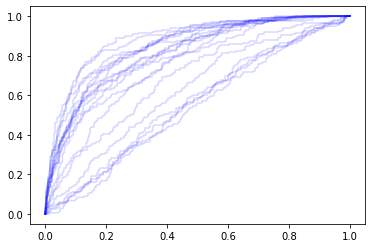

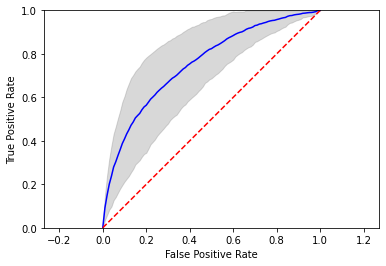

Num_samples: 960
acc:  0.9197916666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8541666666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8447916666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8489583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.828125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.865625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9072916666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.89375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8697916666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.909375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8635416666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9010416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8947916666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8479166666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9145833333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8729166666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.878125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.8666666666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


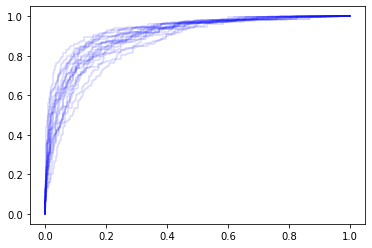

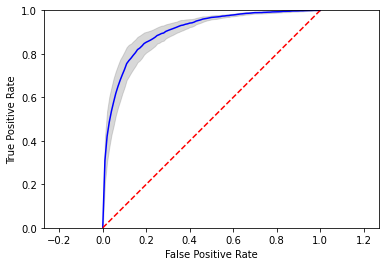

Num_samples: 960
acc:  0.95625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9520833333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.903125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9291666666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9385416666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9322916666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9427083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.95


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9458333333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.94375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9572916666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9510416666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.959375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.959375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.940625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9427083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.925


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.965625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9395833333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9354166666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


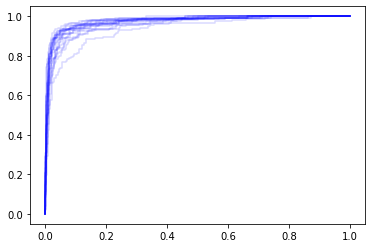

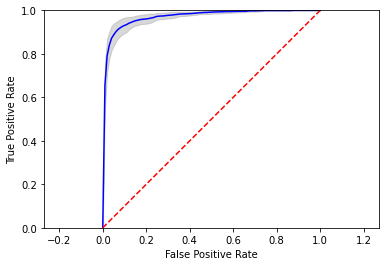

Num_samples: 960
acc:  0.9635416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9708333333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9729166666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9572916666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9645833333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9229166666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.940625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9677083333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9635416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9479166666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9583333333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9708333333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9645833333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.953125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9354166666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9541666666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.95625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9666666666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9583333333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


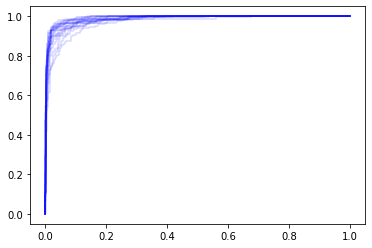

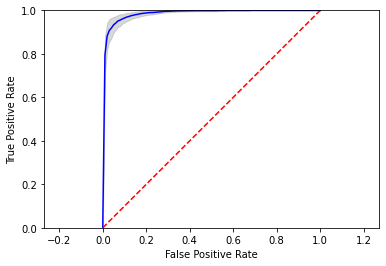

Num_samples: 960
acc:  0.9739583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.98125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9760416666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.98125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.984375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9697916666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9833333333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9489583333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.98125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.98125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9479166666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9322916666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9791666666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9833333333333333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9604166666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9885416666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9854166666666667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 960
acc:  0.9739583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


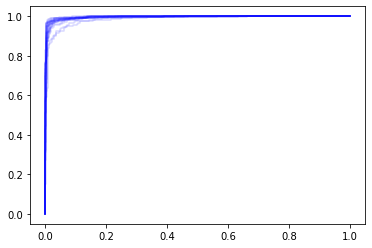

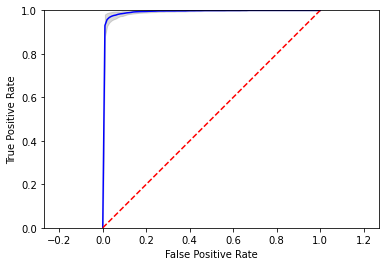

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
from os import walk

# EDIT MODEL PATHS TO USE
models = {0: '/content/models_custom/0/',
          1: '/content/models_custom/1/',
          2: '/content/models_custom/2/',
          3: '/content/models_custom/3/',
          4: '/content/models_custom/4/'
          }
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  tprs = []
  for (dirpath, dirnames, filenames) in walk(models[iii]):
    for files in filenames:
      if files.find('3inputs_custom') != -1:
        test_features= DATA[iii]['MFCCS'][ int(0.5*len(data_x)): int(0.85*len(data_x))]
        test_extra   = DATA[iii]['EXTRA'][ int(0.5*len(data_x)): int(0.85*len(data_x))]
        test_imgs    = DATA[iii]['MEL'][ int(0.5*len(data_x)): int(0.85*len(data_x))]
        test_labels  = DATA[iii]['LABELS'][ int(0.5*len(data_x)): int(0.85*len(data_x))]
        TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))

        model = tf.keras.models.load_model(dirpath + '/' + files)
        y_score = model.predict(TEST)
        fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
        print('Num_samples:', len(y_score))

        print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

        plt.plot(fpr, tpr, 'b', alpha=0.15)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

  tprs = np.array(tprs)
  mean_tprs = tprs.mean(axis=0)
  std = tprs.std(axis=0)

  tprs_upper = np.minimum(mean_tprs + std, 1)
  tprs_lower = mean_tprs - std
  plt.figure()
  plt.plot(base_fpr, mean_tprs, 'b')
  plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.axes().set_aspect('equal', 'datalim')
  plt.savefig('roc_curve.png')
  plt.show()

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
from os import walk

# EDIT MODEL PATHS TO USE
models = {0: '/content/models_vgg/0/',
          1: '/content/models_vgg/1/',
          2: '/content/models_vgg/2/',
          3: '/content/models_vgg/3/',
          4: '/content/models_vgg/4/'
          }
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  tprs = []
  for (dirpath, dirnames, filenames) in walk(models[iii]):
    for files in filenames:
      if files.find('3inputs') != -1:
        test_features= DATA[iii]['MFCCS'][ int(0.5*len(data_x)): int(0.85*len(data_x))]
        test_extra   = DATA[iii]['EXTRA'][ int(0.5*len(data_x)): int(0.85*len(data_x))]
        test_imgs    = DATA[iii]['MEL'][ int(0.5*len(data_x)): int(0.85*len(data_x))]
        test_labels  = DATA[iii]['LABELS'][ int(0.5*len(data_x)): int(0.85*len(data_x))]
        TEST          = TripleInputGenerator_VGG(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(224,224))

        model = tf.keras.models.load_model(dirpath + '/' + files)
        y_score = model.predict(TEST)
        fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
        print('Num_samples:', len(y_score))

        print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

        plt.plot(fpr, tpr, 'b', alpha=0.15)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

  tprs = np.array(tprs)
  mean_tprs = tprs.mean(axis=0)
  std = tprs.std(axis=0)

  tprs_upper = np.minimum(mean_tprs + std, 1)
  tprs_lower = mean_tprs - std
  plt.figure()
  plt.plot(base_fpr, mean_tprs, 'b')
  plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.axes().set_aspect('equal', 'datalim')
  plt.savefig('roc_curve.png')
  plt.show()

InvalidArgumentError: ignored

Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8333333333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8567708333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8697916666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8723958333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8854166666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8854166666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8828125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


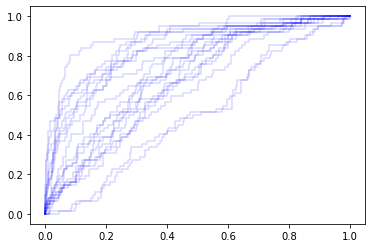

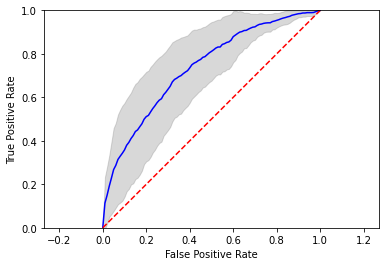

Num_samples: 384
acc:  0.9296875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.90625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9036458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9192708333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8828125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9140625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9453125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9140625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9192708333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9010416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9322916666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9479166666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9348958333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.90625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9192708333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8229166666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9010416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9296875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9505208333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9427083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


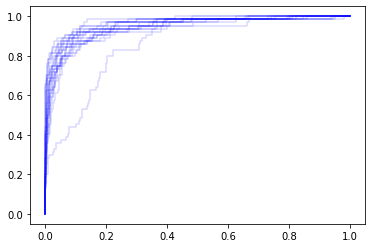

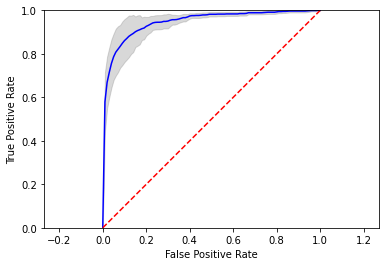

Num_samples: 384
acc:  0.9505208333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.96875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9557291666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9609375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9583333333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9557291666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.96875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.90625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9583333333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9609375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9453125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9609375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9270833333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9661458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9479166666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9479166666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9479166666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9583333333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.96875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.953125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


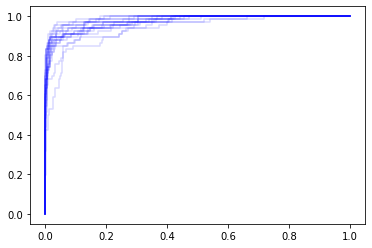

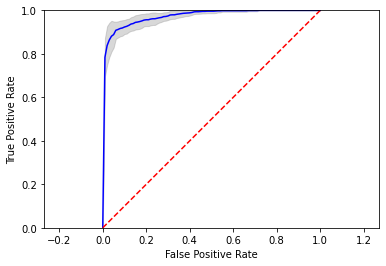

Num_samples: 384
acc:  0.9713541666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9557291666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9661458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9791666666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9244791666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9270833333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9635416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9739583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9739583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9739583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.96875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9505208333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9739583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9661458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9739583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9635416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9739583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9739583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9635416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9739583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


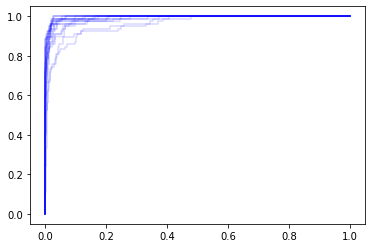

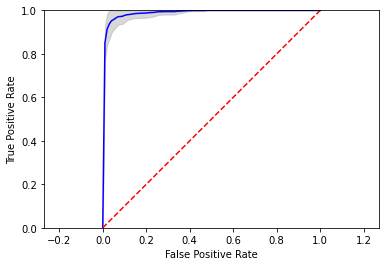

Num_samples: 384
acc:  0.9791666666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9765625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9739583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9765625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.984375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9817708333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9739583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9739583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9609375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9713541666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9661458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9583333333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9791666666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.953125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9713541666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9765625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9765625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9661458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9427083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.9713541666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


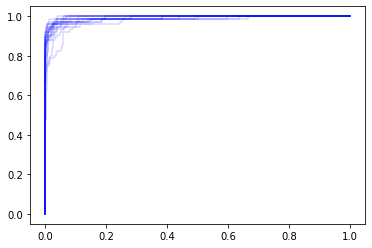

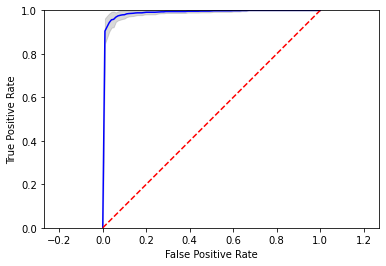

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
from os import walk

# EDIT MODEL PATHS TO USE
models = {0: '/content/models_custom/0/',
          1: '/content/models_custom/1/',
          2: '/content/models_custom/2/',
          3: '/content/models_custom/3/',
          4: '/content/models_custom/4/'
          }
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  tprs = []
  for (dirpath, dirnames, filenames) in walk(models[iii]):
    for files in filenames:
      if files.find('2inputs_custom') != -1:
        test_features= DATA[iii]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
        test_imgs    = DATA[iii]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
        test_labels  = DATA[iii]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
        TEST          = DoubleInputGenerator(test_features,test_imgs,test_labels,batch_size=48,target_size=(64,64))

        model = tf.keras.models.load_model(dirpath + '/' + files)
        y_score = model.predict(TEST)
        fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
        print('Num_samples:', len(y_score))

        print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

        plt.plot(fpr, tpr, 'b', alpha=0.15)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

  tprs = np.array(tprs)
  mean_tprs = tprs.mean(axis=0)
  std = tprs.std(axis=0)

  tprs_upper = np.minimum(mean_tprs + std, 1)
  tprs_lower = mean_tprs - std
  plt.figure()
  plt.plot(base_fpr, mean_tprs, 'b')
  plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.axes().set_aspect('equal', 'datalim')
  plt.savefig('roc_curve.png')
  plt.show()

Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8177083333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


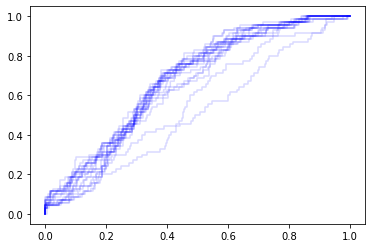

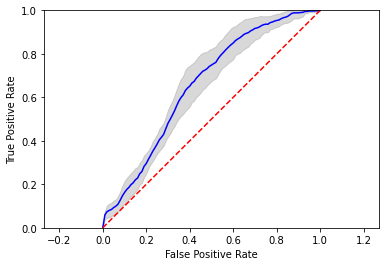

Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.84375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8333333333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8359375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.84375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


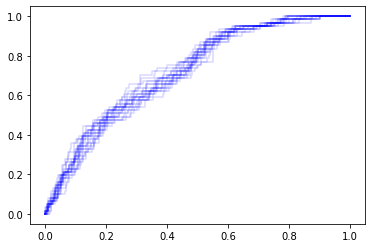

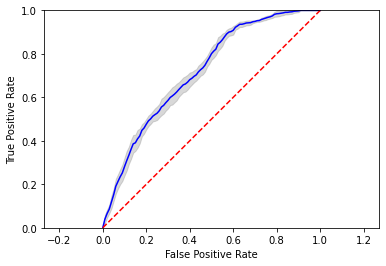

Num_samples: 384
acc:  0.84375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8463541666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8489583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.84375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8463541666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8463541666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.84375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8515625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.84375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8385416666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8489583333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 384
acc:  0.8411458333333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


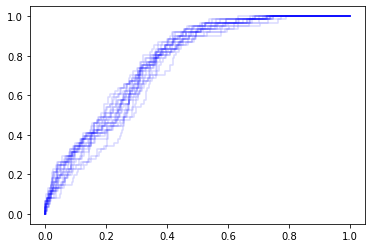

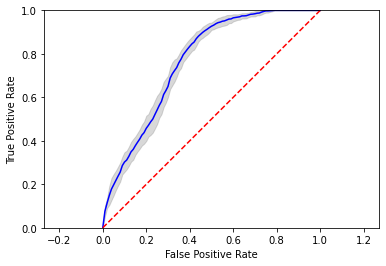

OSError: ignored

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
from os import walk

# EDIT MODEL PATHS TO USE
models = {0: '/content/models_vgg/0/',
          1: '/content/models_vgg/1/',
          2: '/content/models_vgg/2/',
          3: '/content/models_vgg/3/',
          4: '/content/models_vgg/4/'
          }
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  tprs = []
  for (dirpath, dirnames, filenames) in walk(models[iii]):
    for files in filenames:
      if files.find('2inputs') != -1:
        test_features= DATA[iii]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
        test_imgs    = DATA[iii]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
        test_labels  = DATA[iii]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
        TEST          = DoubleInputGenerator_VGG(test_features,test_imgs,test_labels,batch_size=48,target_size=(224,224))

        model = tf.keras.models.load_model(dirpath + '/' + files)
        y_score = model.predict(TEST)
        fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
        print('Num_samples:', len(y_score))

        print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

        plt.plot(fpr, tpr, 'b', alpha=0.15)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

  tprs = np.array(tprs)
  mean_tprs = tprs.mean(axis=0)
  std = tprs.std(axis=0)

  tprs_upper = np.minimum(mean_tprs + std, 1)
  tprs_lower = mean_tprs - std
  plt.figure()
  plt.plot(base_fpr, mean_tprs, 'b')
  plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.axes().set_aspect('equal', 'datalim')
  plt.savefig('roc_curve.png')
  plt.show()

Model Name =  006--0.512--0.484--3inputs_custom.hdf5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.84      1.00      0.91       322
           1       0.00      0.00      0.00        62

    accuracy                           0.84       384
   macro avg       0.42      0.50      0.46       384
weighted avg       0.70      0.84      0.76       384

Model Name =  002--0.506--0.478--2inputs_custom.hdf5
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       322
           1       0.00      0.00      0.00        62

    accuracy                           0.84       384
   macro avg       0.42      0.50      0.46       384
weighted avg       0.70      0.84      0.76       384

Model Name =  001--0.524--0.528--2inputs_custom.hdf5
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       322
           1       0.00      0.00      0.00        62

    accuracy                           0.84       384
   macro avg       0.4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


              precision    recall  f1-score   support

           0       0.92      0.93      0.92       322
           1       0.61      0.60      0.60        62

    accuracy                           0.87       384
   macro avg       0.76      0.76      0.76       384
weighted avg       0.87      0.87      0.87       384

Model Name =  013--0.573--0.301--2inputs_custom.hdf5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


              precision    recall  f1-score   support

           0       0.90      0.93      0.92       322
           1       0.57      0.47      0.51        62

    accuracy                           0.86       384
   macro avg       0.73      0.70      0.71       384
weighted avg       0.85      0.86      0.85       384

Model Name =  019--0.739--0.296--3inputs_custom.hdf5
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       322
           1       0.94      0.26      0.41        62

    accuracy                           0.88       384
   macro avg       0.91      0.63      0.67       384
weighted avg       0.89      0.88      0.85       384

Model Name =  013--0.606--0.393--3inputs_custom.hdf5
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       322
           1       0.57      0.19      0.29        62

    accuracy                           0.85       384
   macro avg       0.7

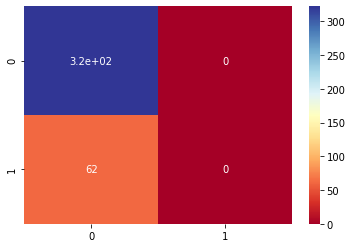

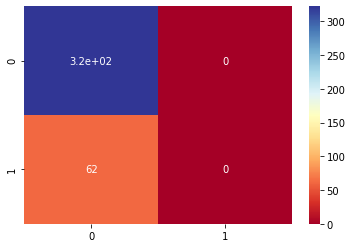

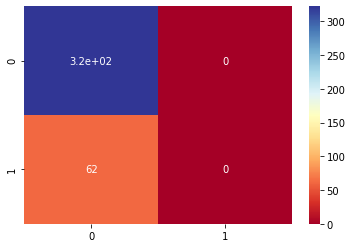

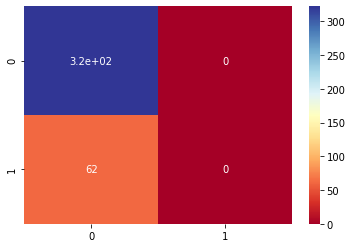

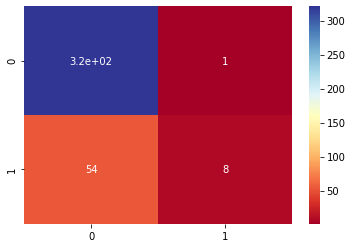

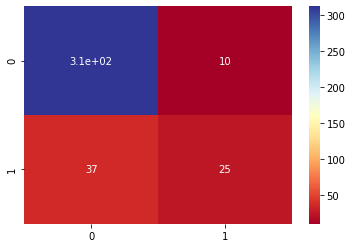

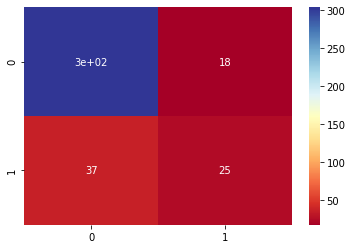

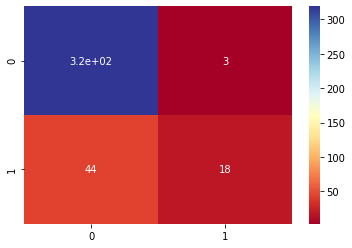

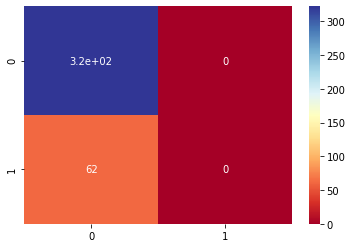

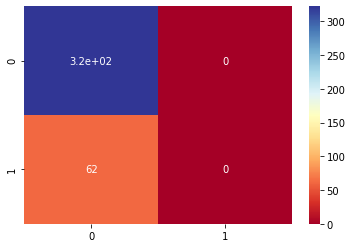

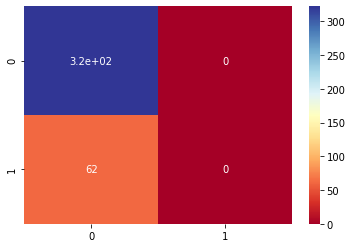

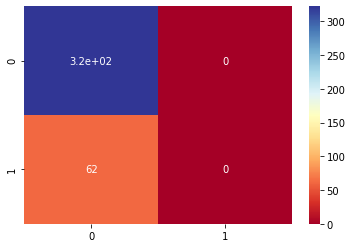

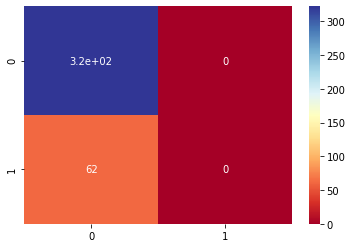

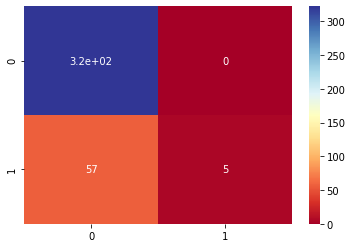

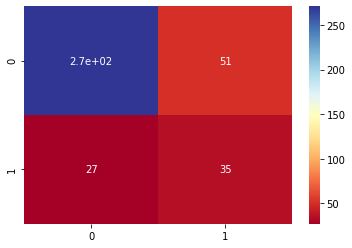

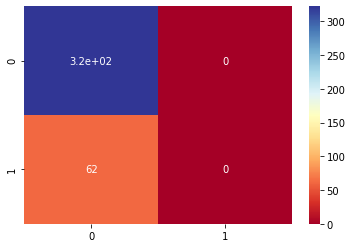

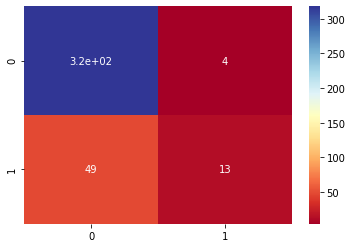

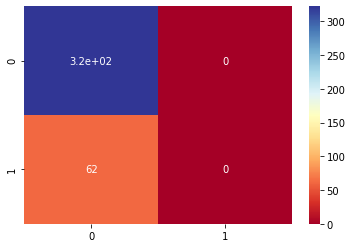

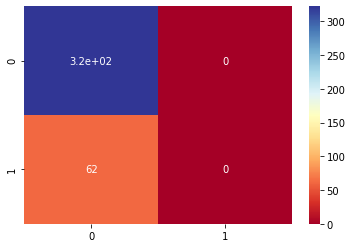

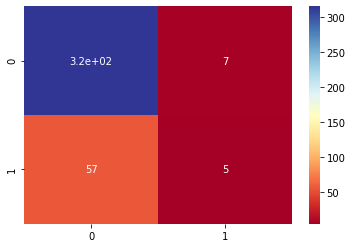

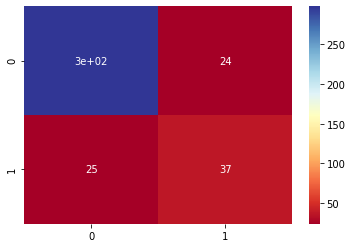

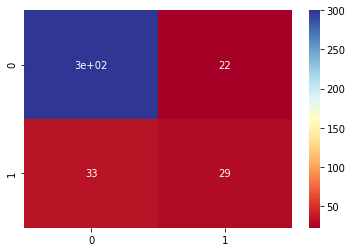

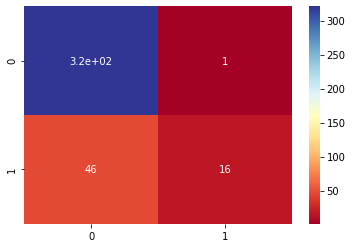

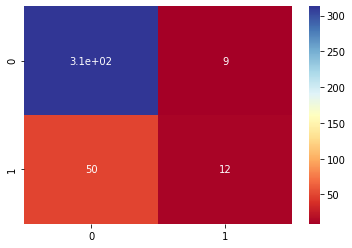

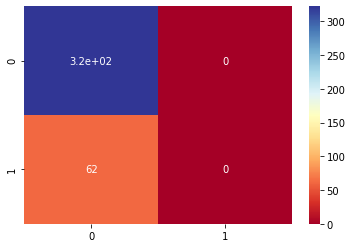

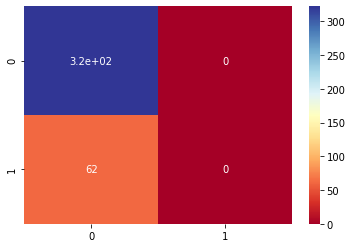

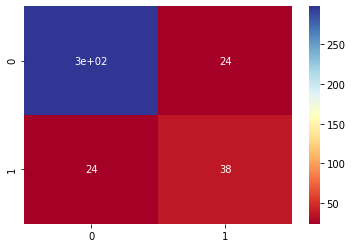

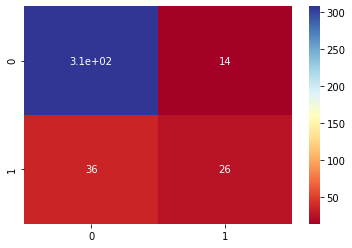

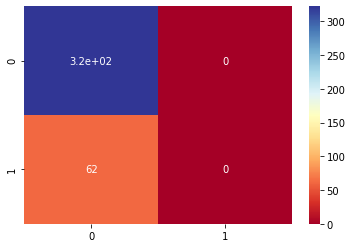

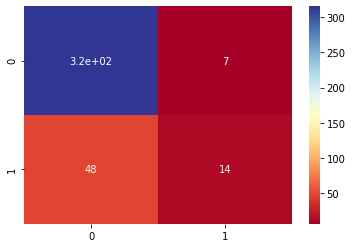

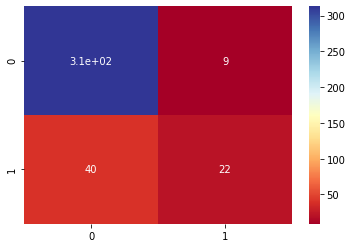

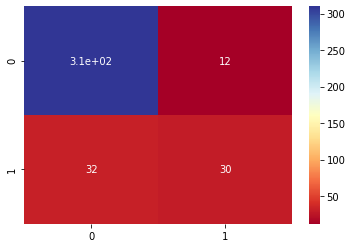

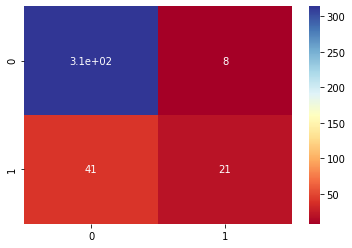

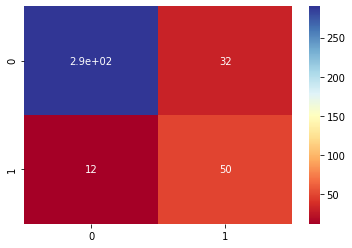

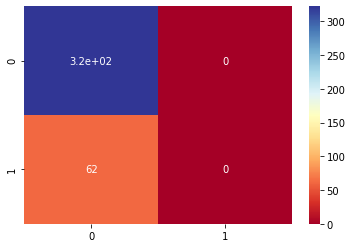

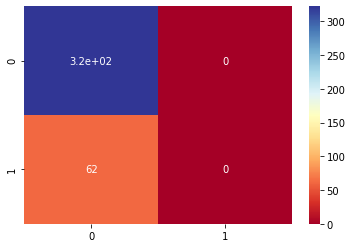

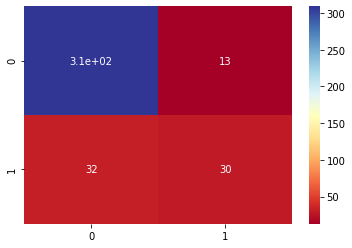

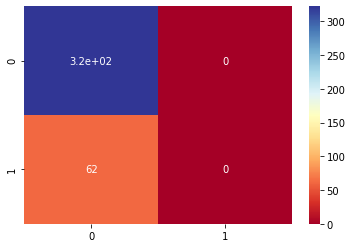

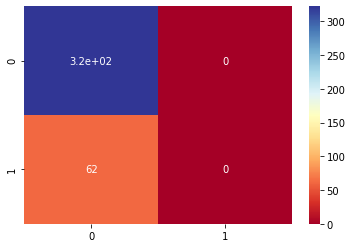

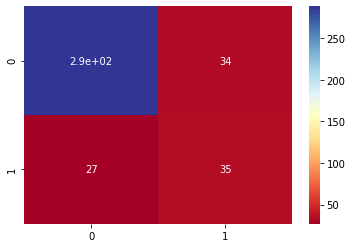

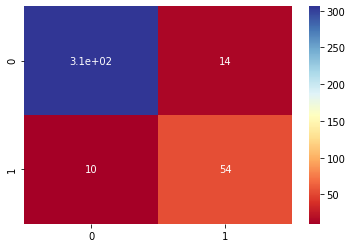

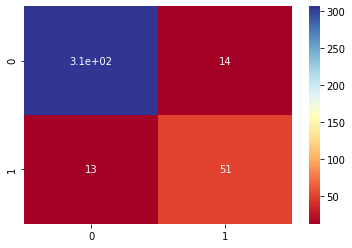

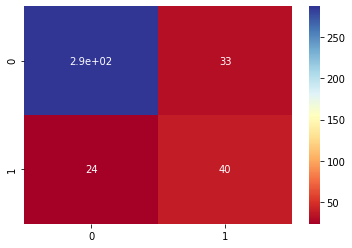

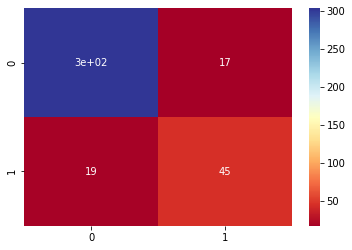

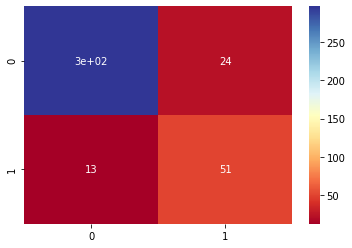

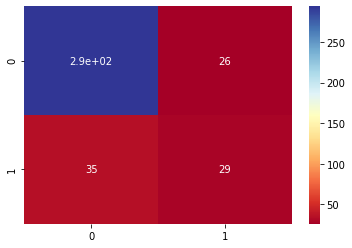

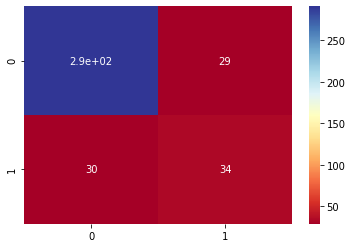

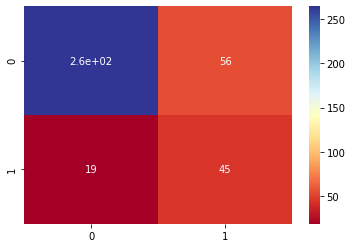

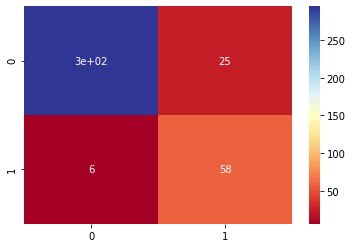

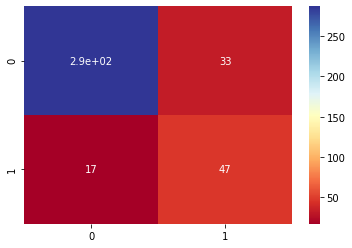

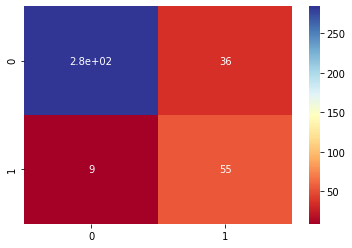

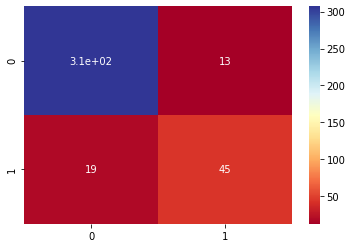

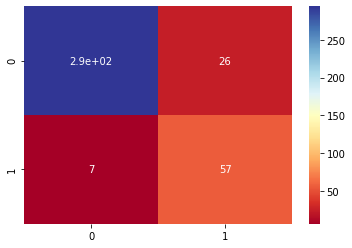

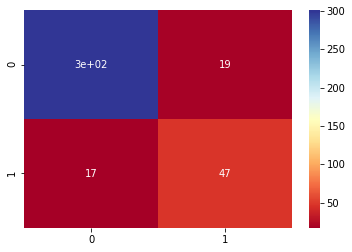

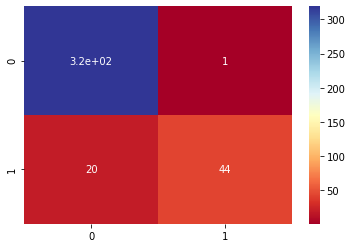

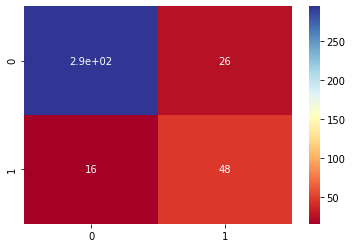

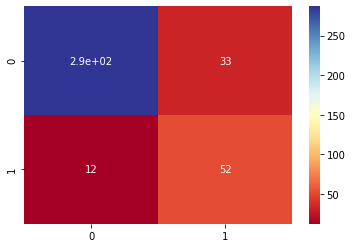

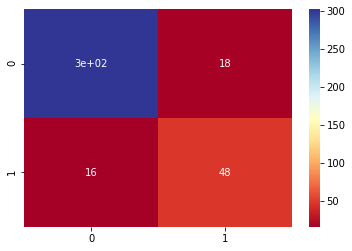

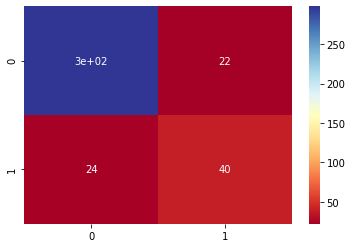

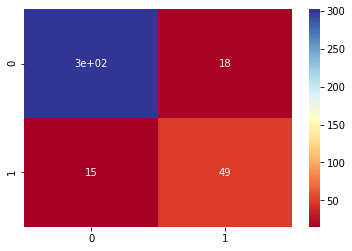

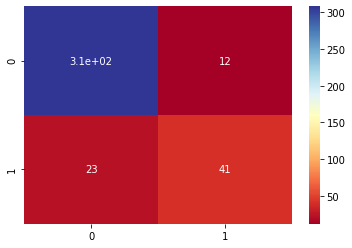

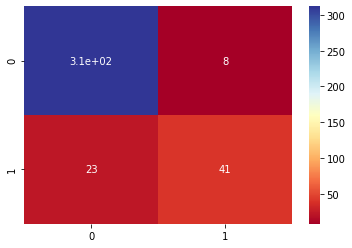

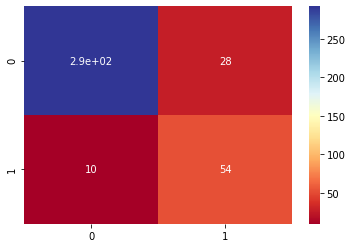

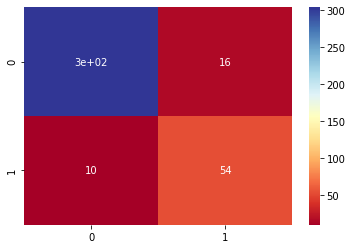

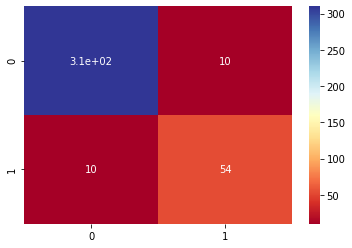

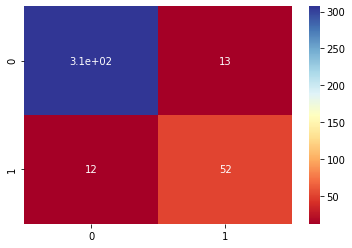

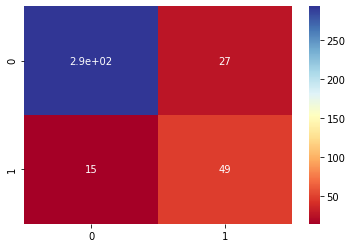

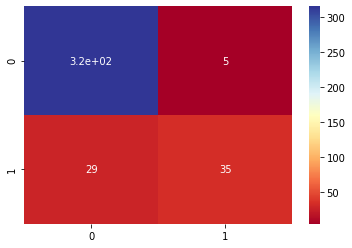

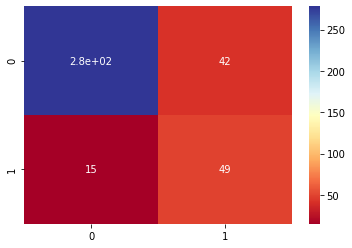

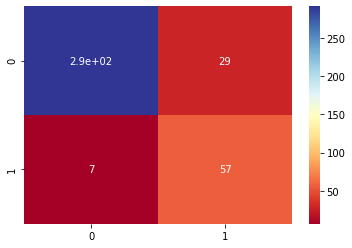

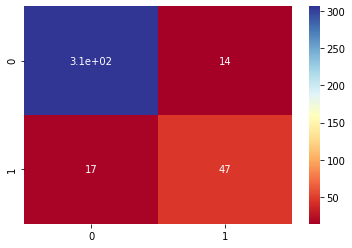

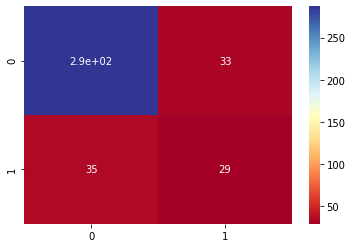

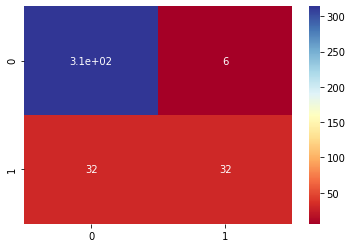

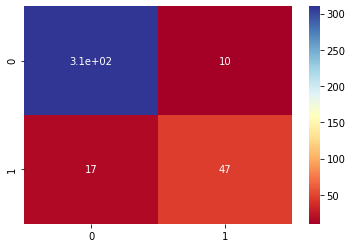

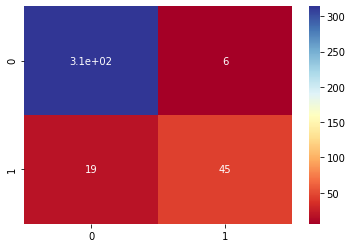

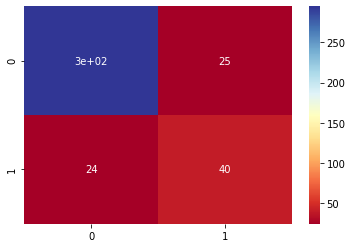

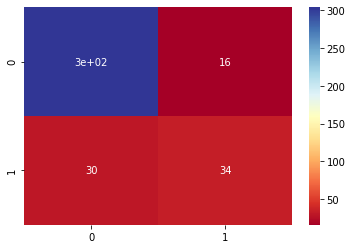

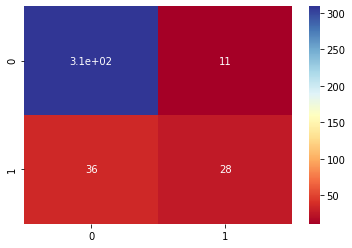

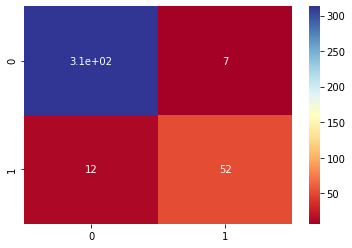

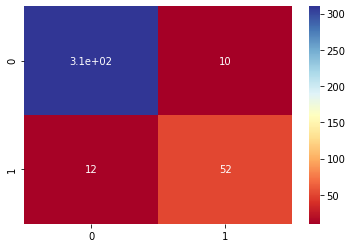

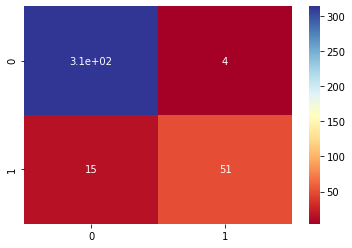

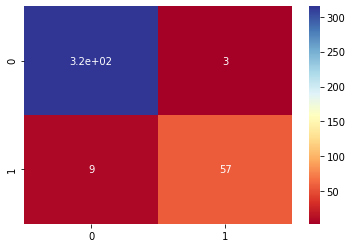

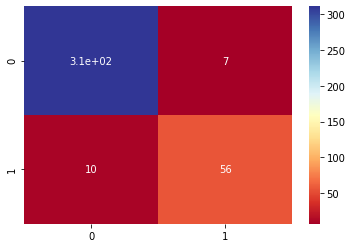

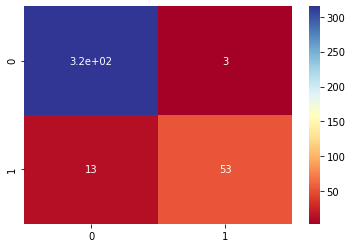

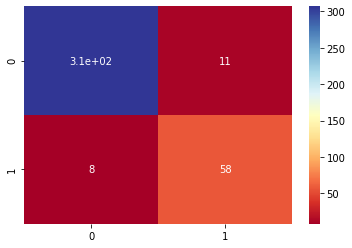

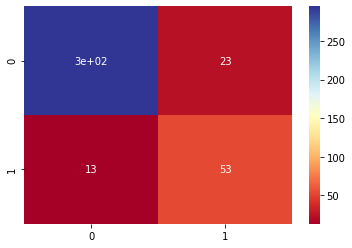

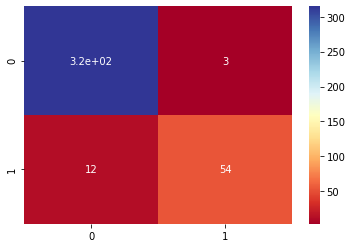

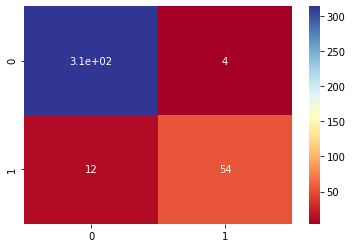

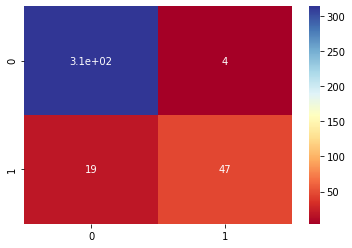

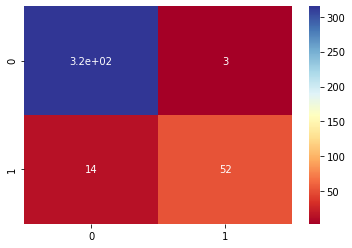

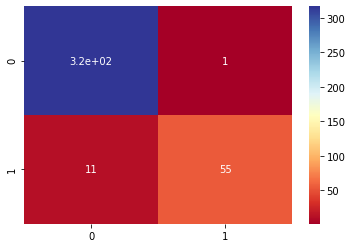

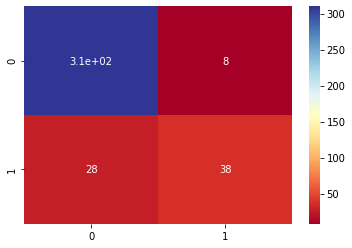

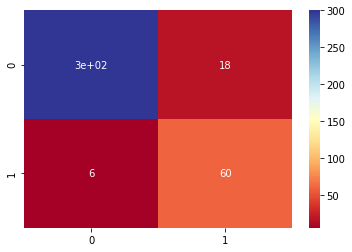

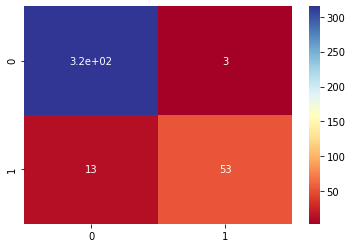

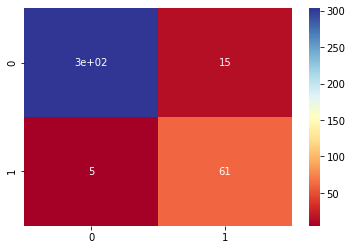

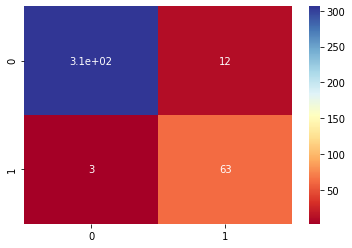

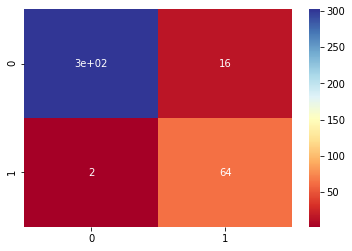

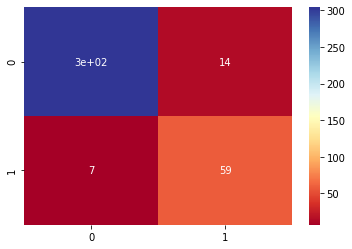

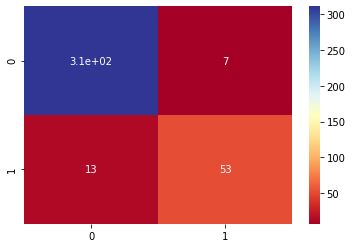

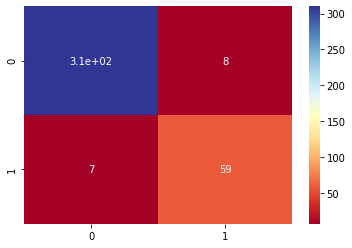

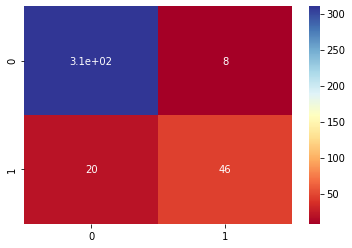

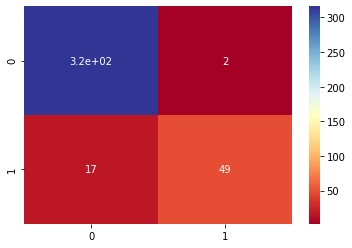

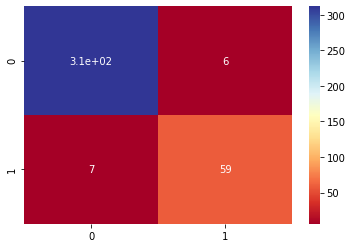

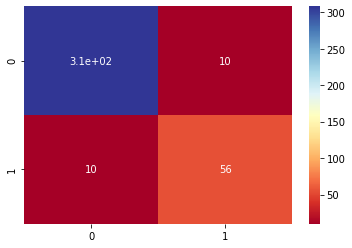

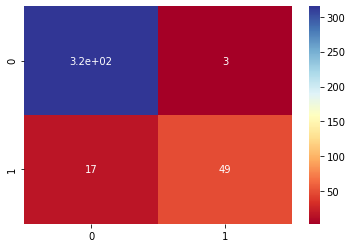

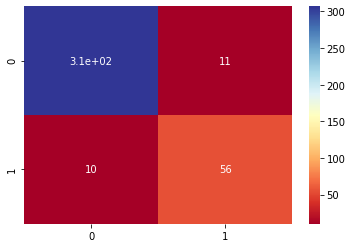

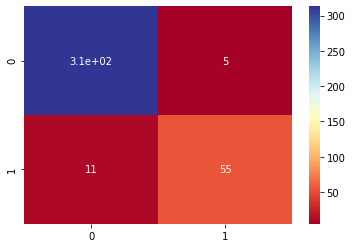

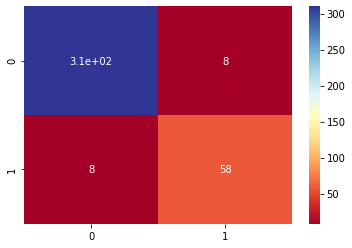

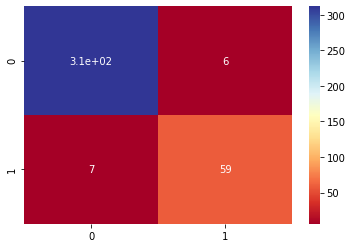

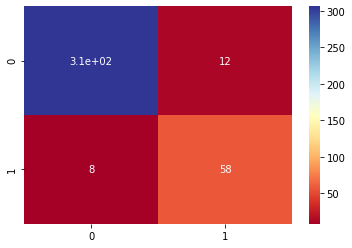

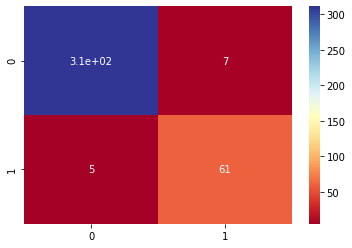

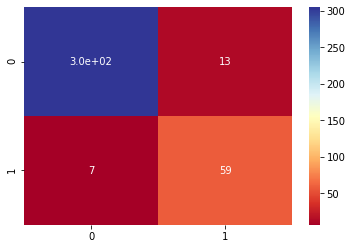

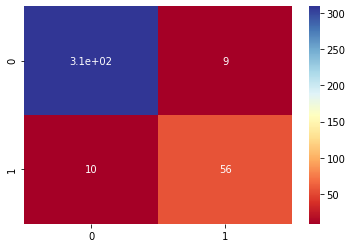

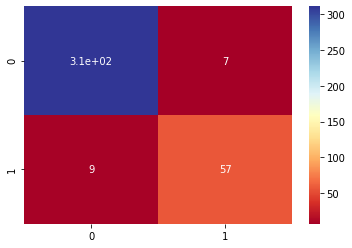

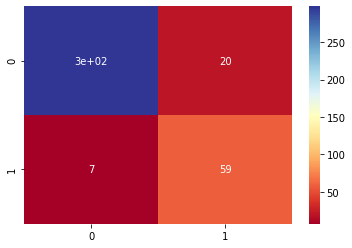

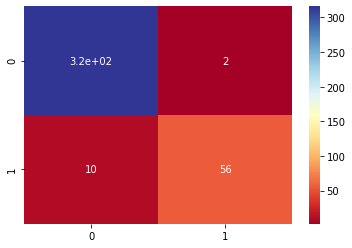

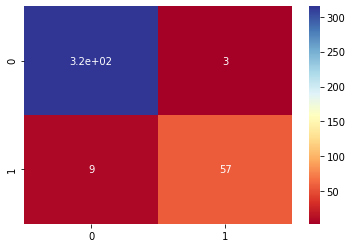

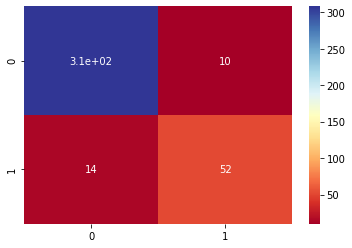

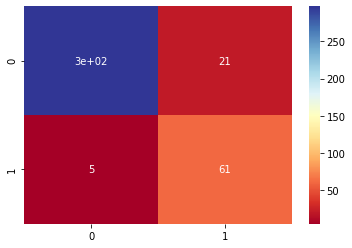

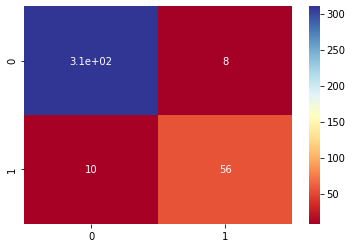

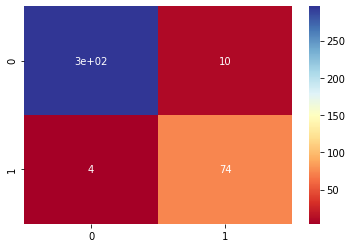

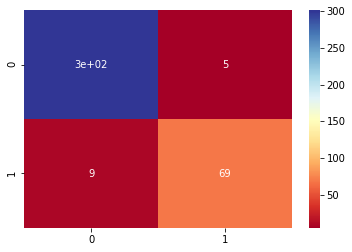

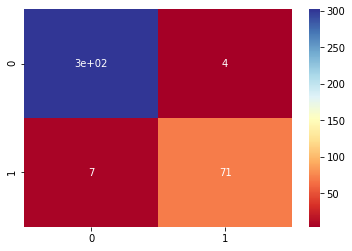

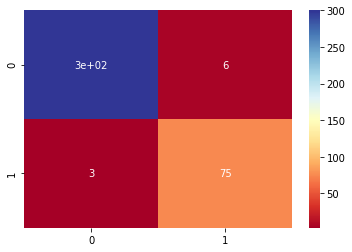

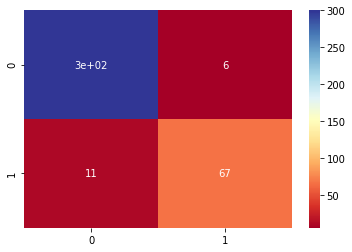

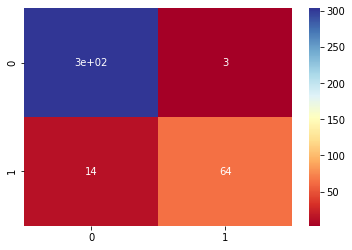

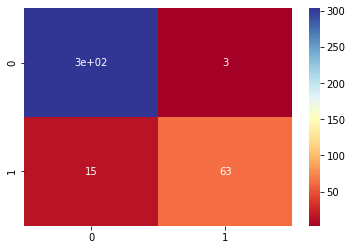

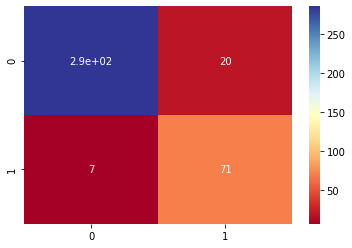

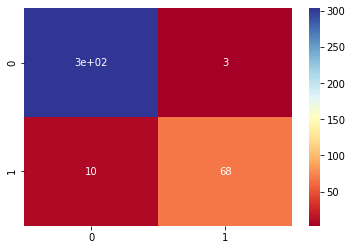

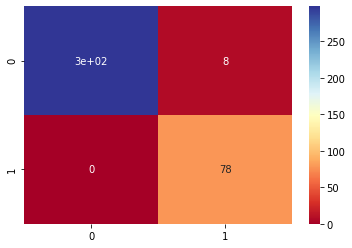

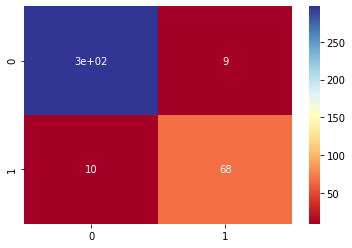

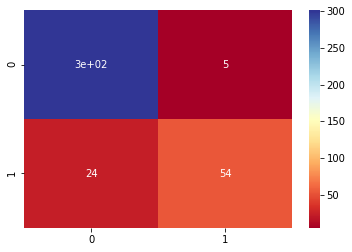

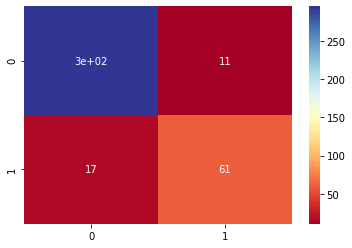

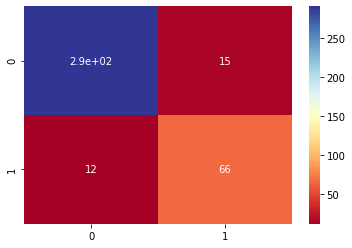

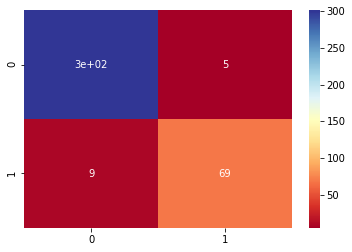

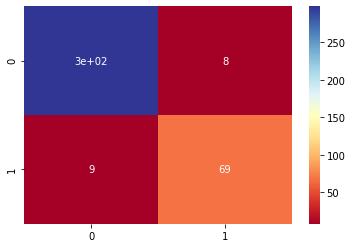

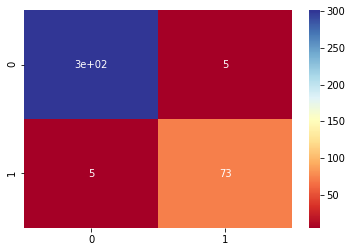

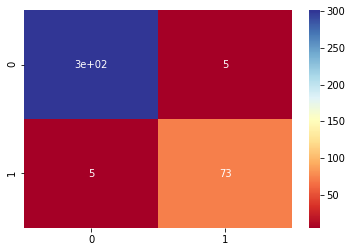

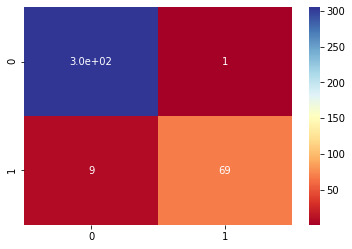

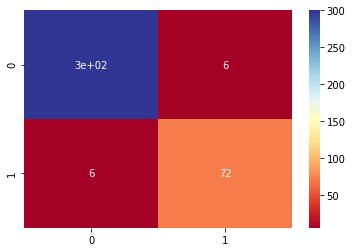

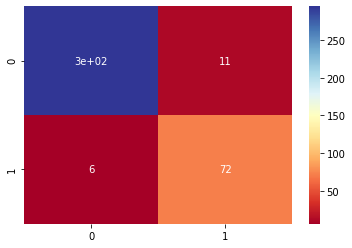

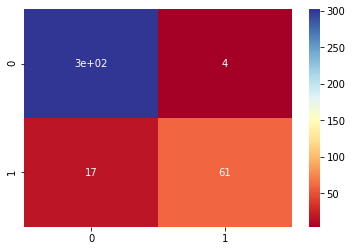

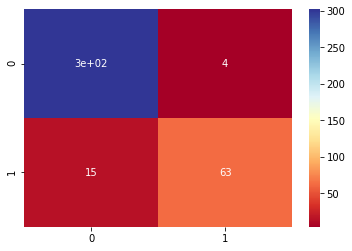

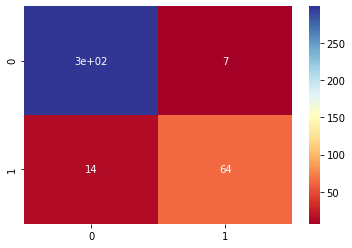

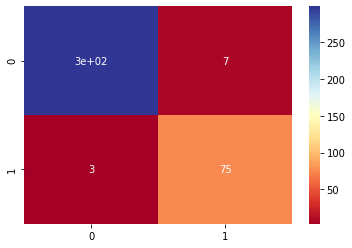

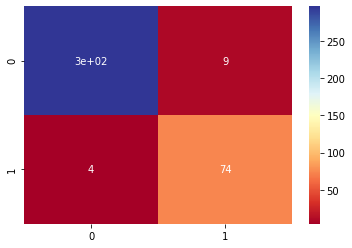

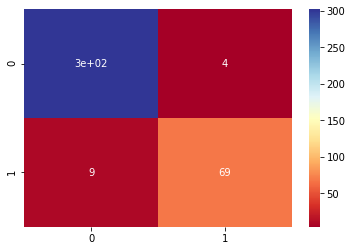

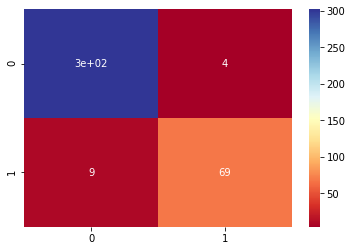

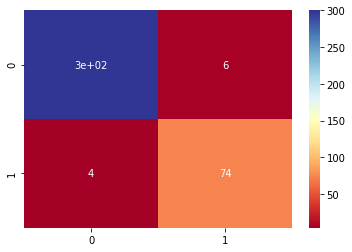

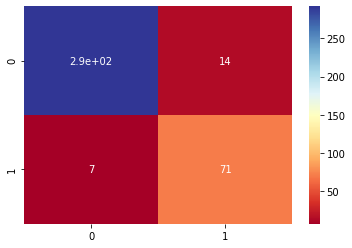

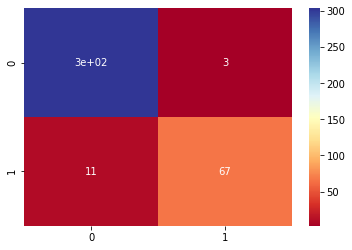

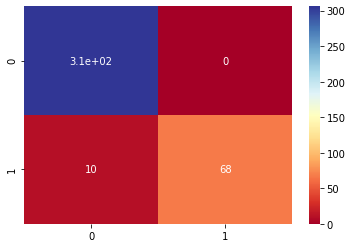

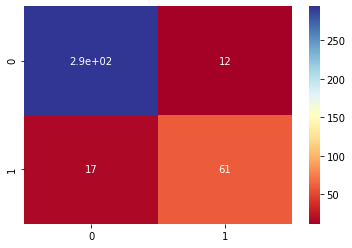

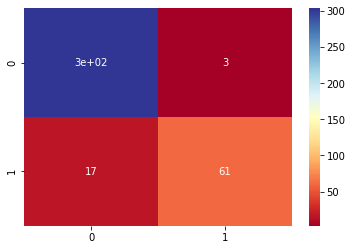

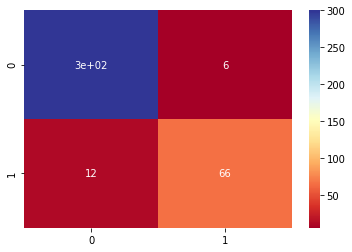

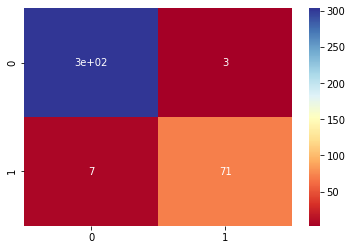

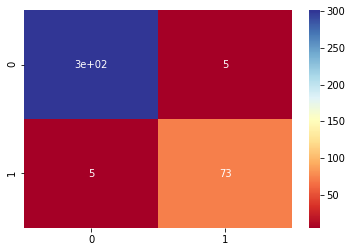

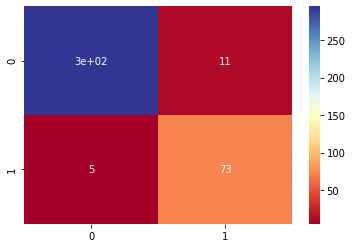

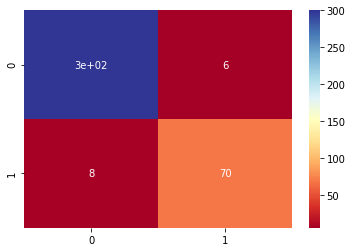

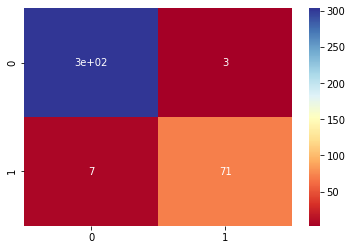

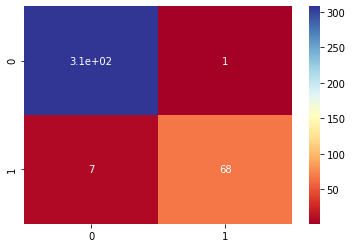

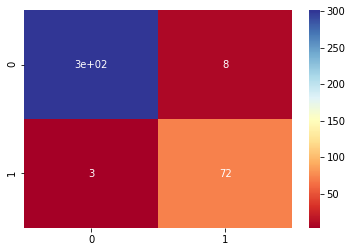

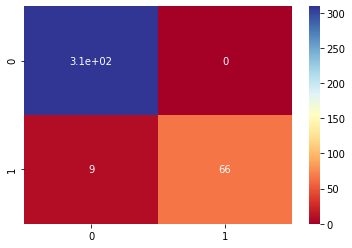

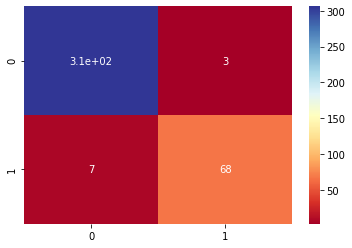

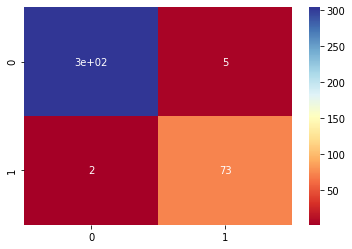

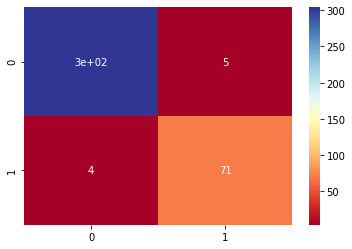

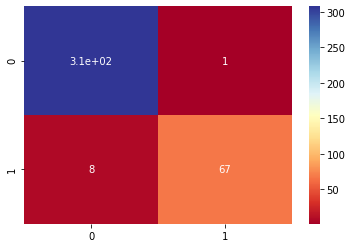

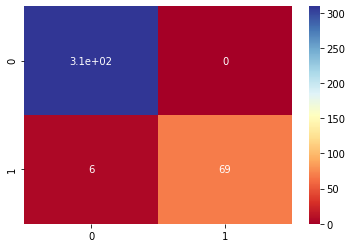

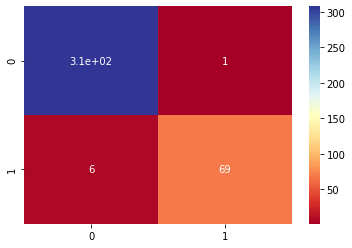

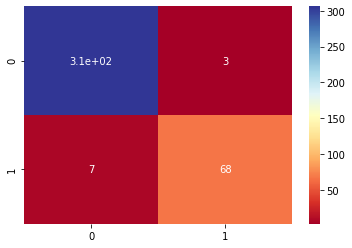

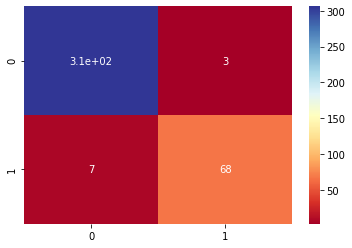

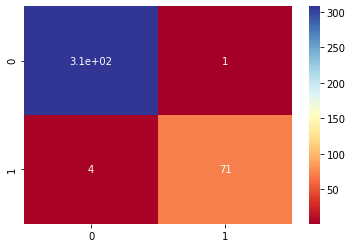

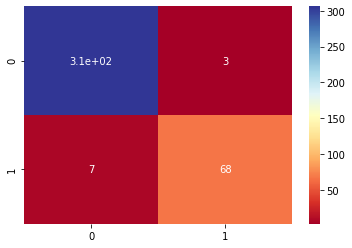

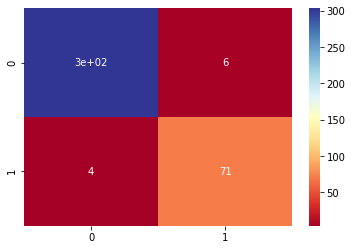

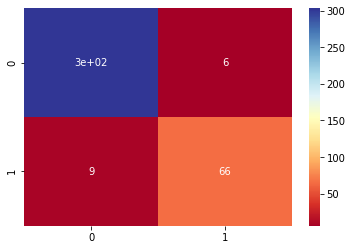

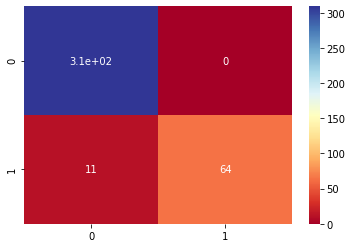

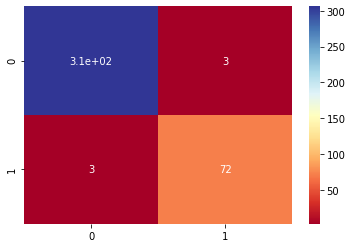

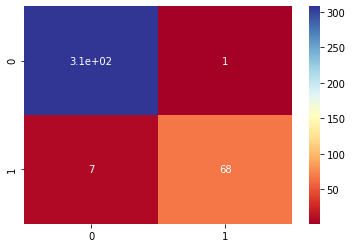

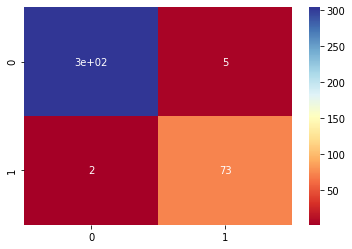

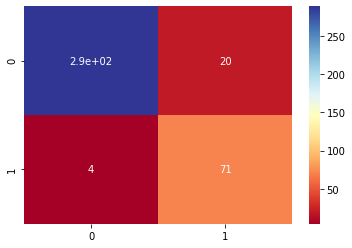

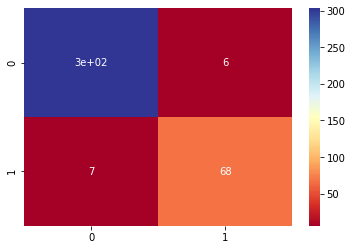

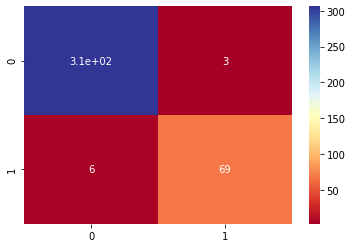

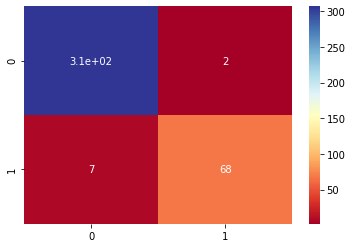

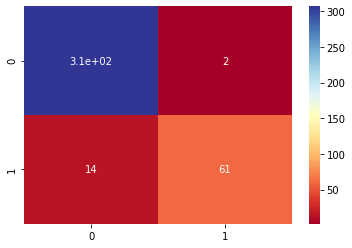

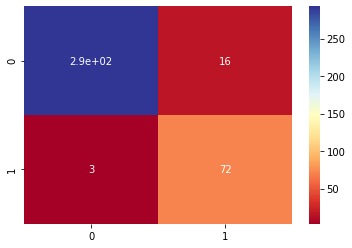

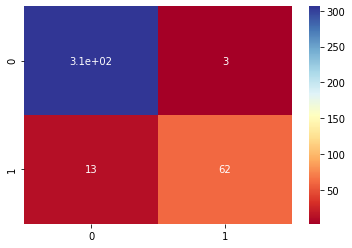

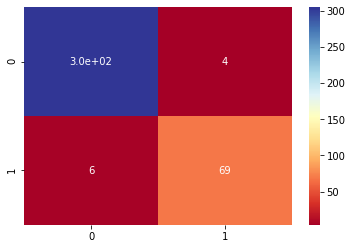

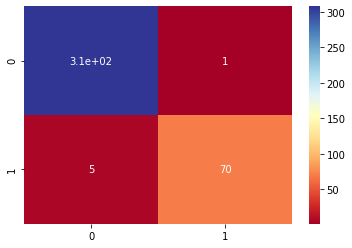

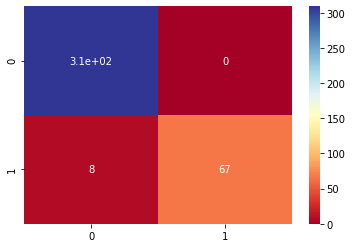

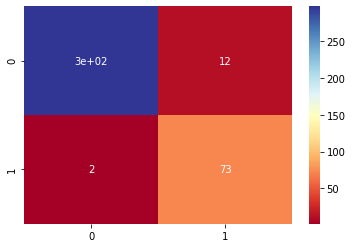

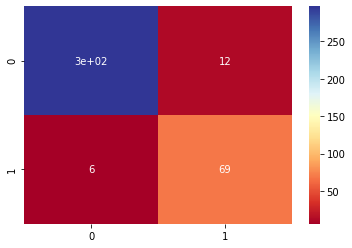

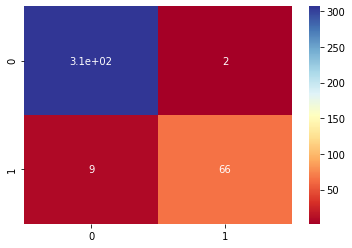

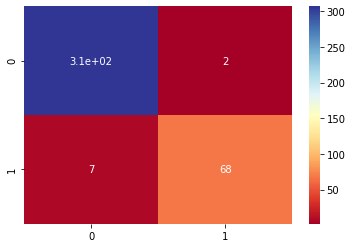

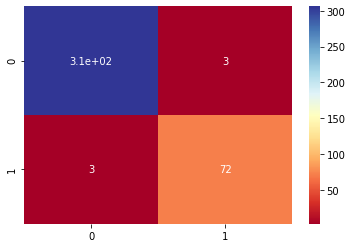

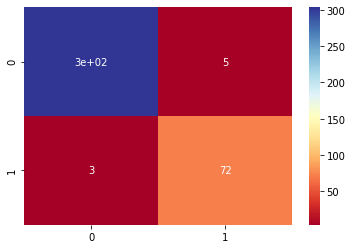

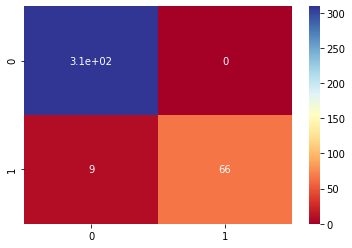

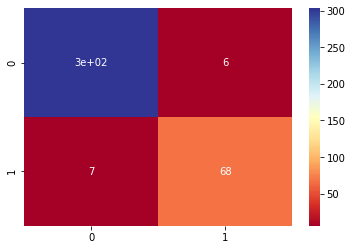

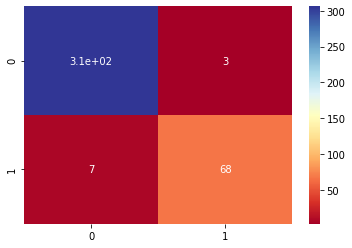

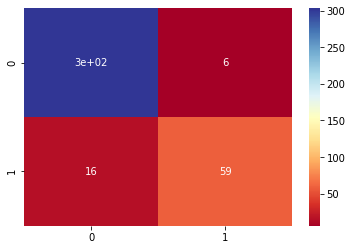

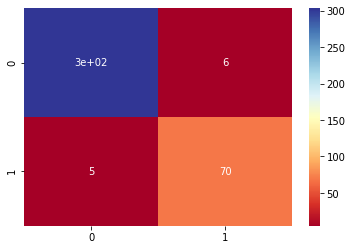

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
for iii in range(5):
  test_features= DATA[iii]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[iii]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[iii]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[iii]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  TEST_2input  = DoubleInputGenerator(test_features,test_imgs,test_labels,batch_size=48,target_size=(64,64))
  TEST_3input  = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  for (dirpath, dirnames, filenames) in walk(models[iii]):
    for files in filenames:
      if files.find('2inputs_custom') != -1:
        print('Model Name = ', files)
        best_model = tf.keras.models.load_model(dirpath + '/' + files)
        y_pred = best_model.predict(TEST_2input)
        plt.figure()
        print(metrics.classification_report(test_labels[:len(y_score)], y_pred>0.5))
        sns.heatmap(metrics.confusion_matrix(test_labels[:len(y_score)], y_pred>0.5), cmap ="RdYlBu", annot = True) 
      if files.find('3inputs_custom') != -1:
        print('Model Name = ', files)
        best_model = tf.keras.models.load_model(dirpath + '/' + files)
        y_pred = best_model.predict(TEST_3input)
        plt.figure()
        print(metrics.classification_report(test_labels[:len(y_score)], y_pred>0.5))
        sns.heatmap(metrics.confusion_matrix(test_labels[:len(y_score)], y_pred>0.5), cmap ="RdYlBu", annot = True) 


Model Name =  004--0.471--0.508--2inputs_VGG.hdf5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.82      1.00      0.90       314
           1       0.00      0.00      0.00        70

    accuracy                           0.82       384
   macro avg       0.41      0.50      0.45       384
weighted avg       0.67      0.82      0.74       384

Model Name =  011--0.452--0.445--2inputs_VGG.hdf5
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       314
           1       0.00      0.00      0.00        70

    accuracy                           0.82       384
   macro avg       0.41      0.50      0.45       384
weighted avg       0.67      0.82      0.74       384

Model Name =  010--0.466--0.448--2inputs_VGG.hdf5
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       314
           1       0.00      0.00      0.00        70

    accuracy                           0.82       384
   macro avg       0.41     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


              precision    recall  f1-score   support

           0       0.82      1.00      0.90       314
           1       0.00      0.00      0.00        70

    accuracy                           0.82       384
   macro avg       0.41      0.50      0.45       384
weighted avg       0.67      0.82      0.74       384

Model Name =  005--0.484--0.474--2inputs_VGG.hdf5
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       314
           1       0.00      0.00      0.00        70

    accuracy                           0.82       384
   macro avg       0.41      0.50      0.45       384
weighted avg       0.67      0.82      0.74       384

Model Name =  005--0.447--0.430--3inputs_VGG.hdf5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


              precision    recall  f1-score   support

           0       0.88      0.96      0.91       314
           1       0.68      0.39      0.49        70

    accuracy                           0.85       384
   macro avg       0.78      0.67      0.70       384
weighted avg       0.84      0.85      0.84       384

Model Name =  016--0.435--0.394--3inputs_VGG.hdf5
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       314
           1       0.76      0.31      0.44        70

    accuracy                           0.86       384
   macro avg       0.81      0.65      0.68       384
weighted avg       0.85      0.86      0.83       384

Model Name =  014--0.459--0.441--2inputs_VGG.hdf5
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       314
           1       0.00      0.00      0.00        70

    accuracy                           0.82       384
   macro avg       0.41     

OSError: ignored

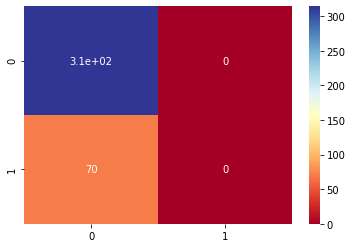

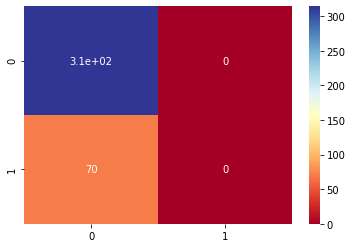

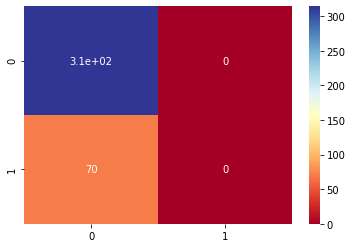

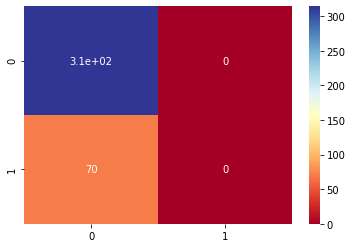

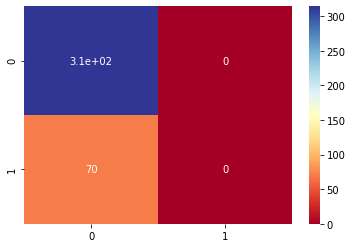

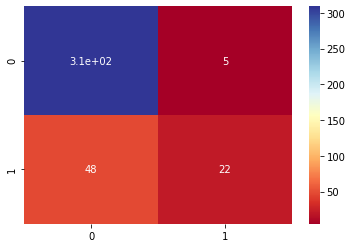

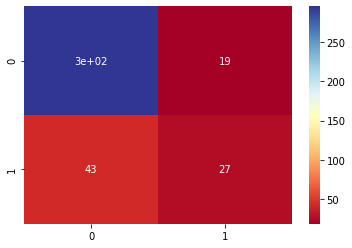

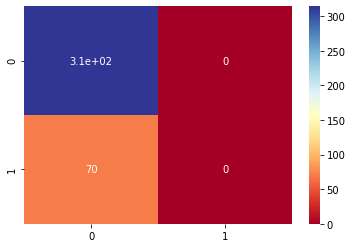

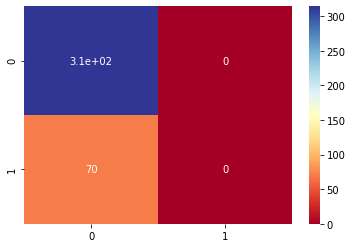

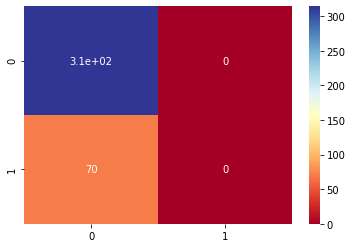

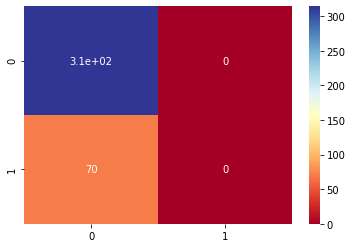

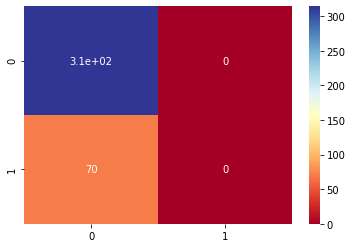

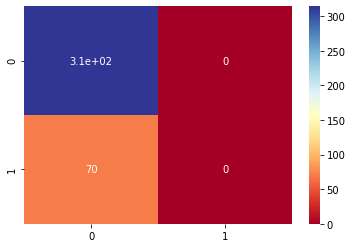

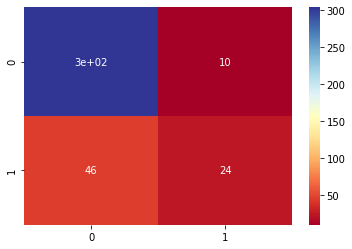

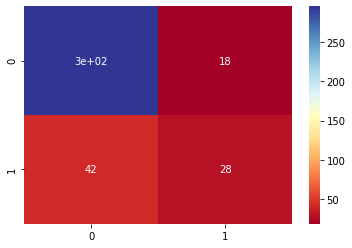

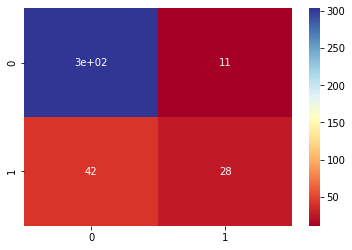

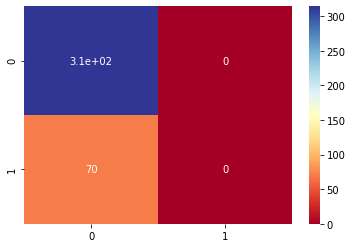

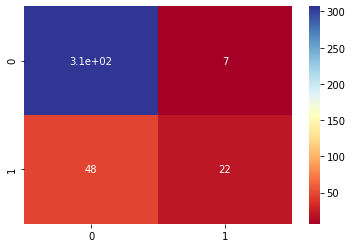

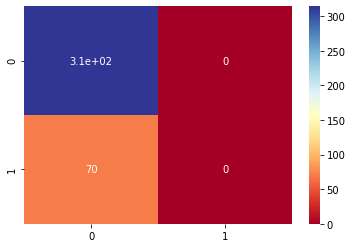

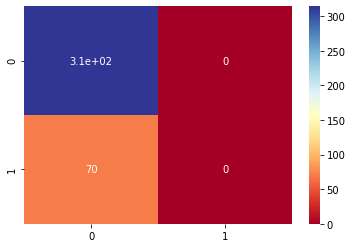

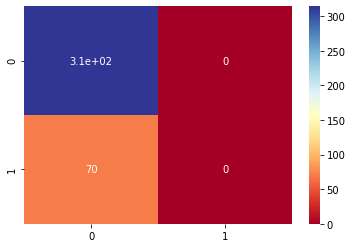

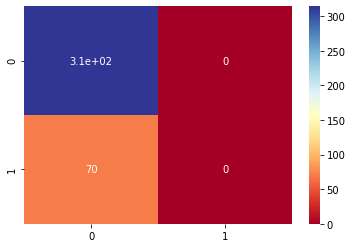

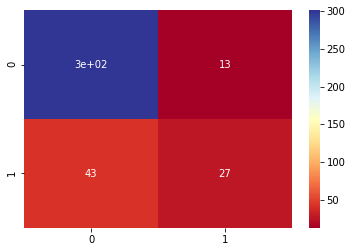

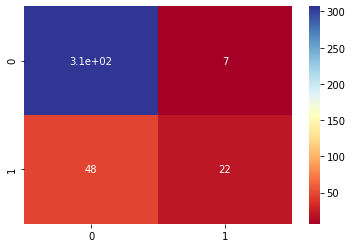

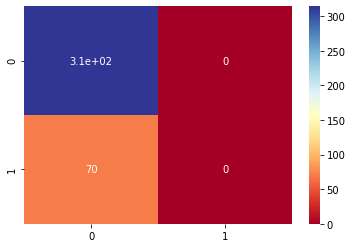

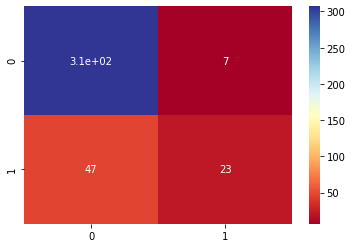

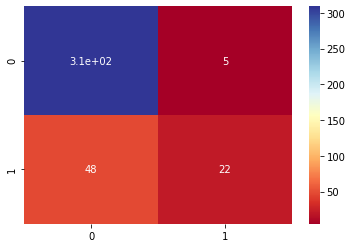

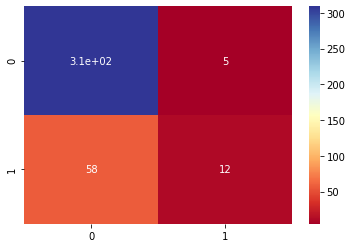

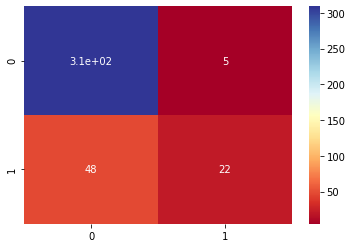

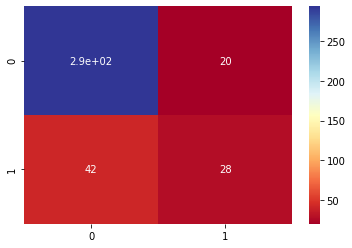

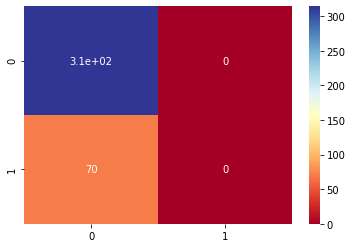

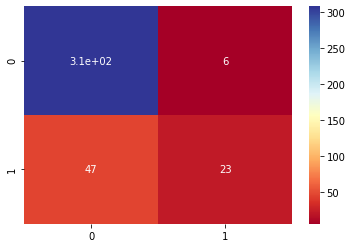

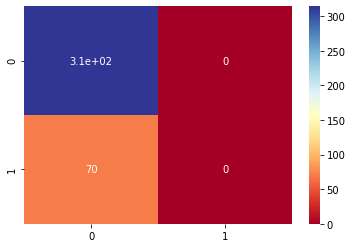

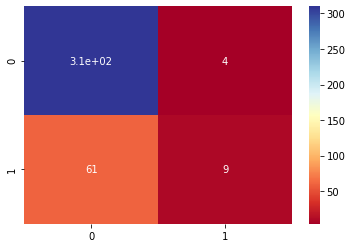

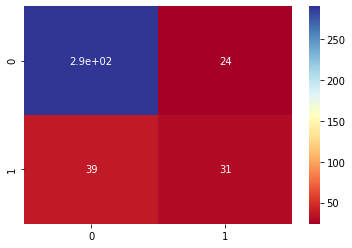

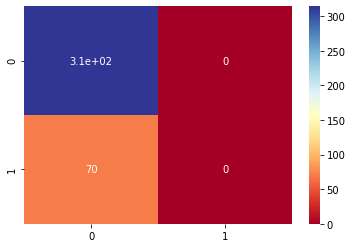

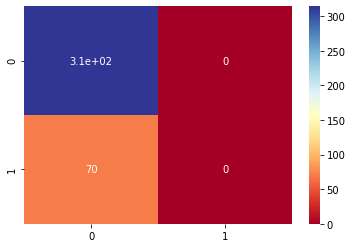

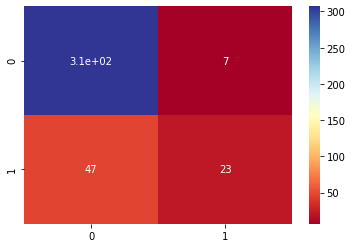

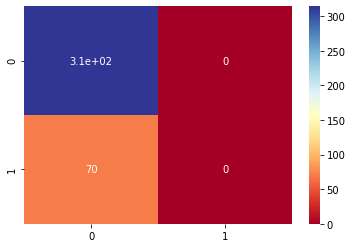

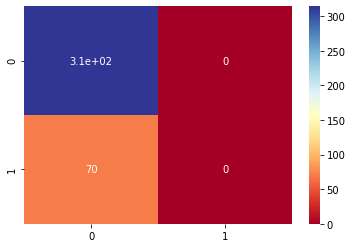

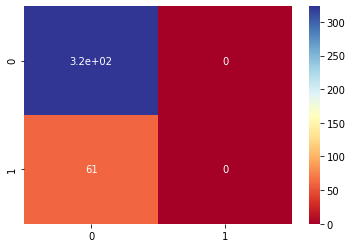

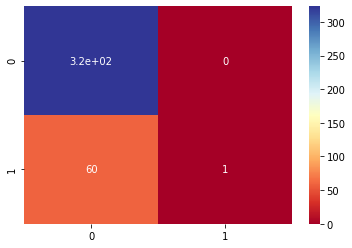

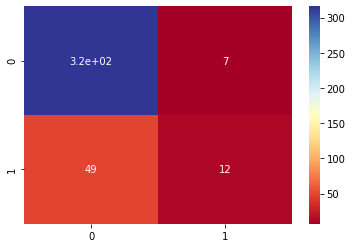

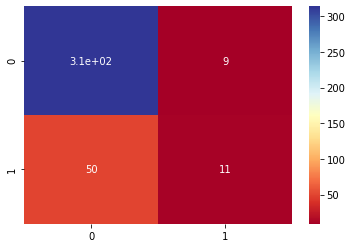

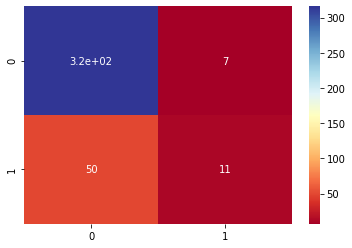

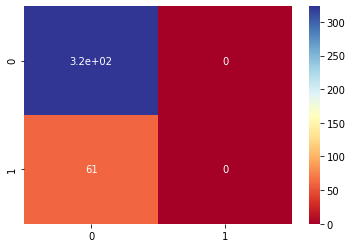

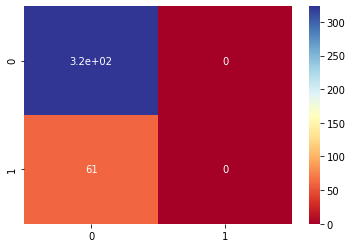

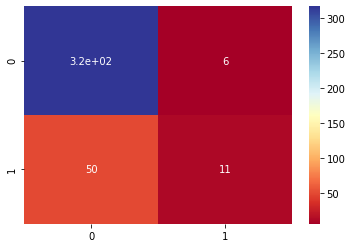

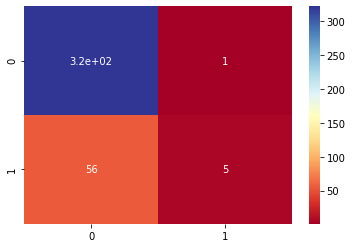

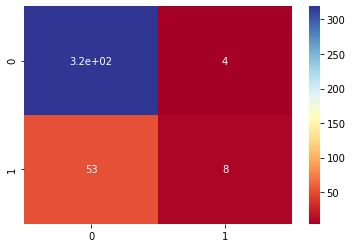

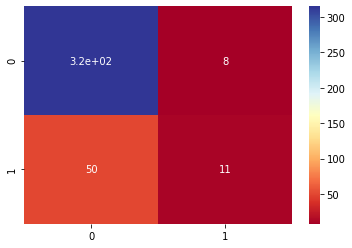

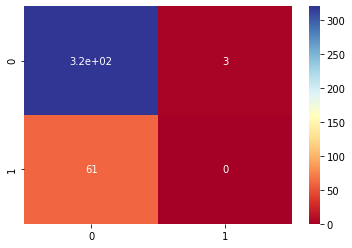

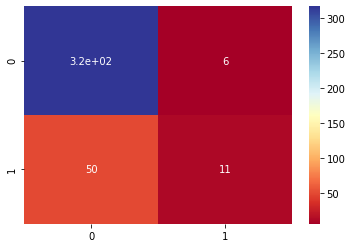

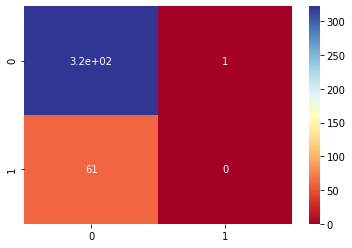

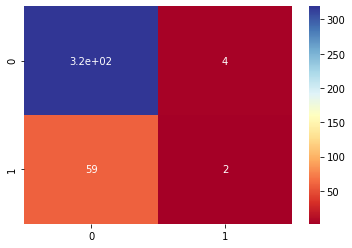

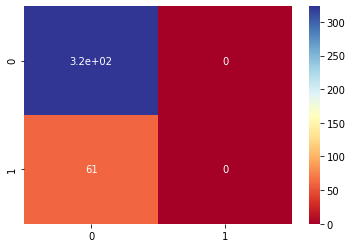

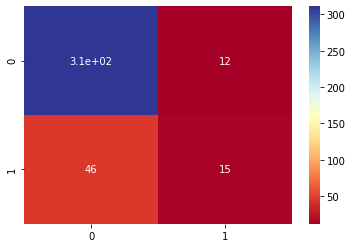

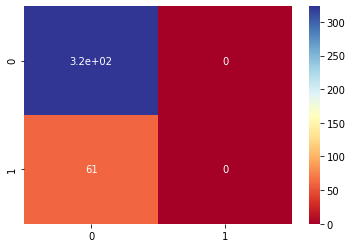

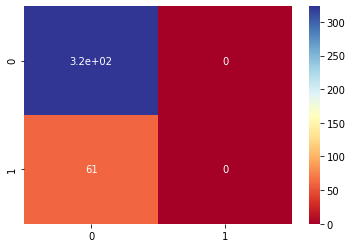

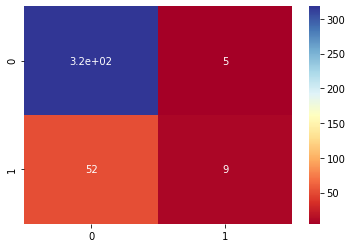

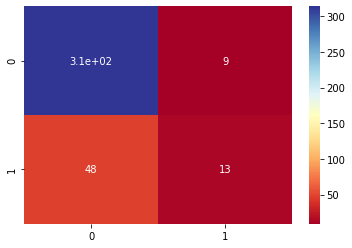

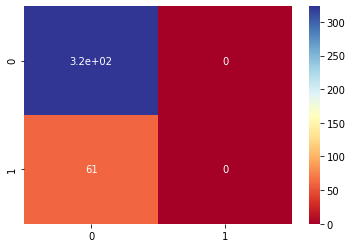

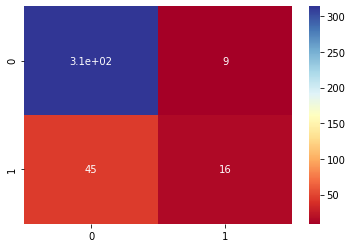

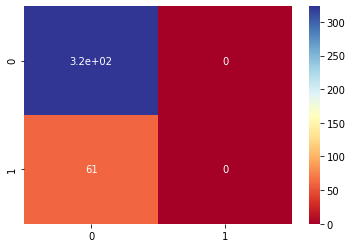

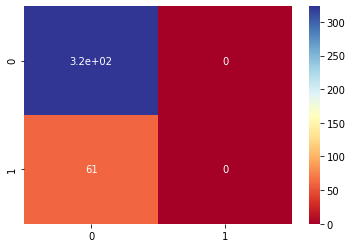

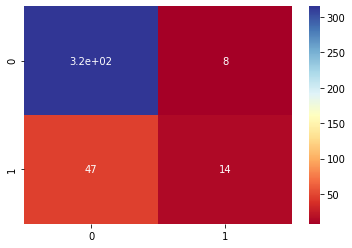

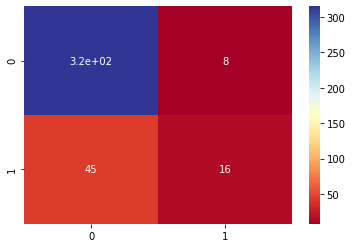

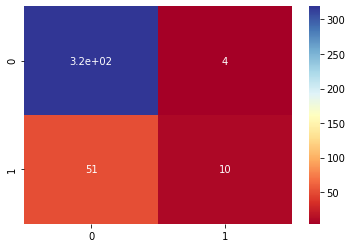

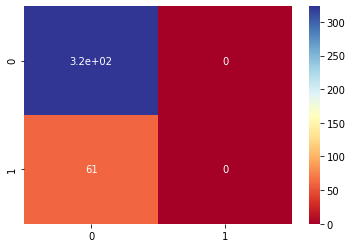

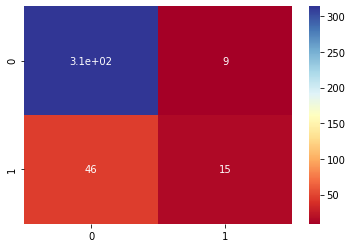

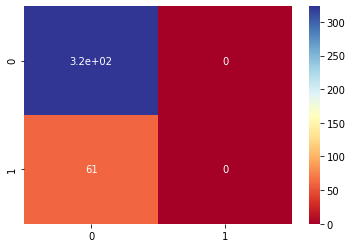

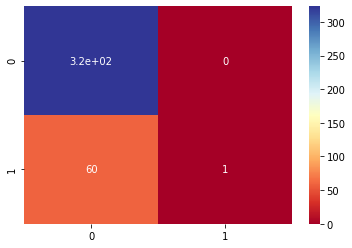

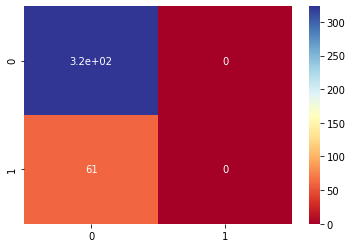

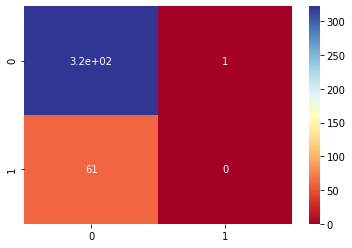

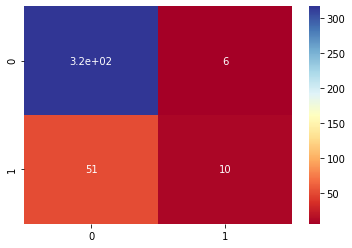

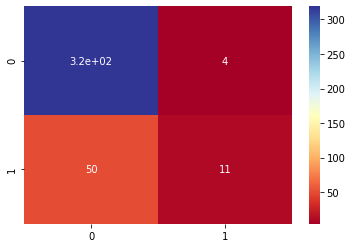

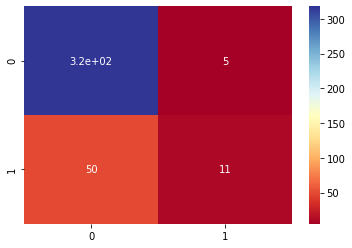

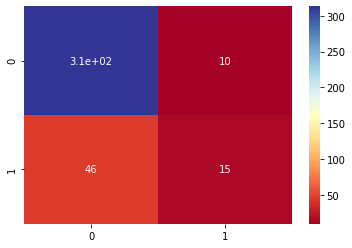

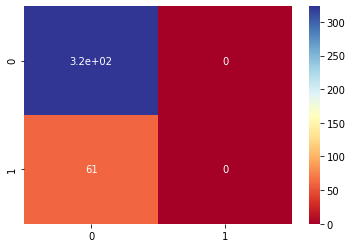

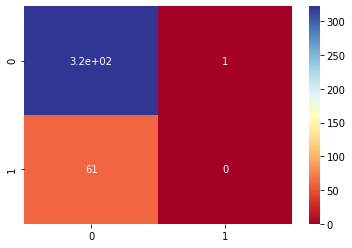

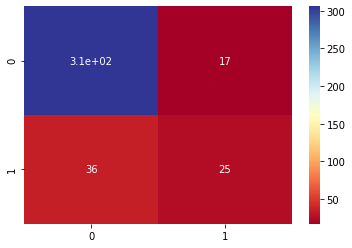

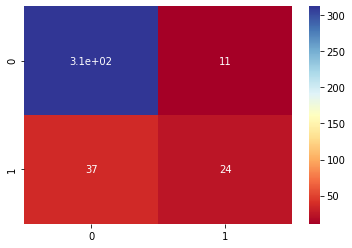

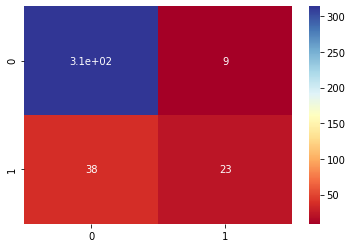

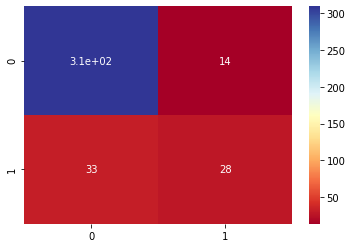

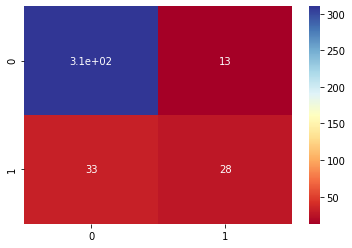

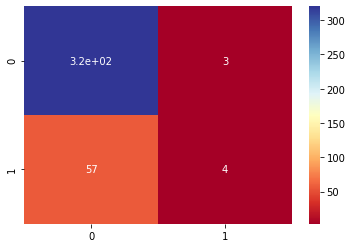

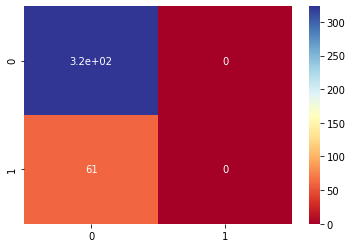

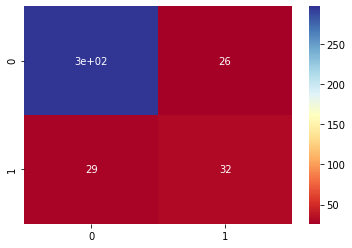

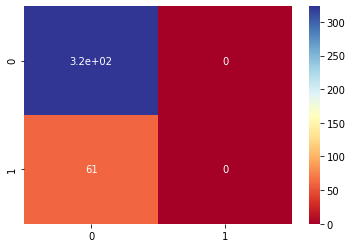

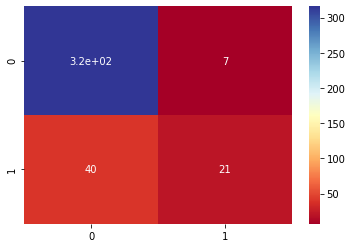

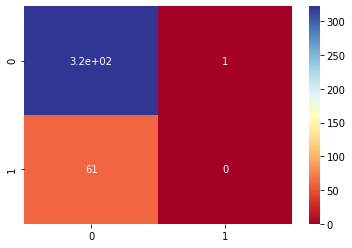

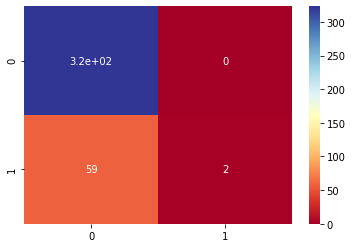

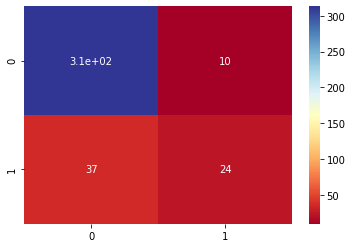

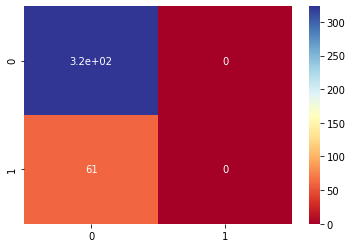

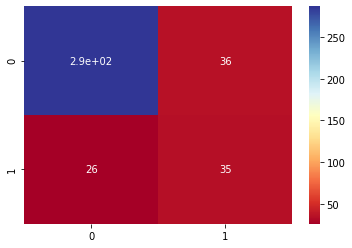

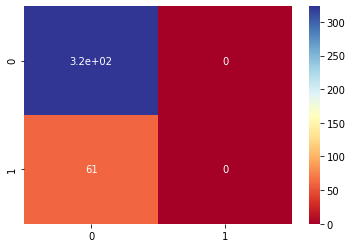

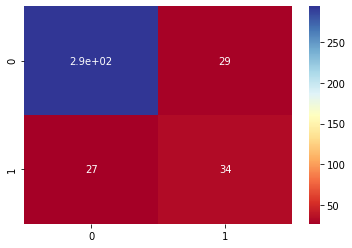

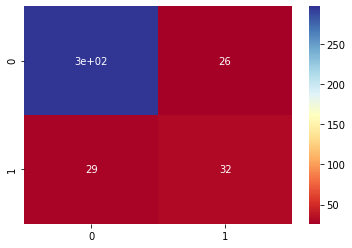

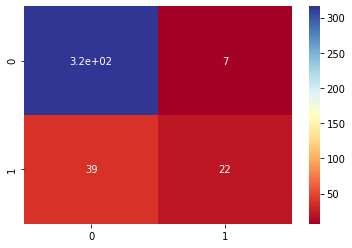

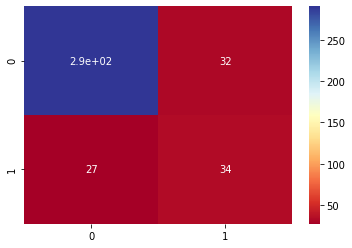

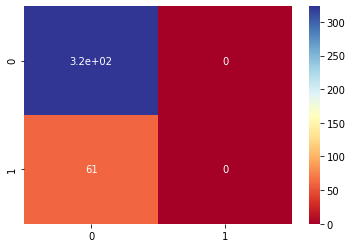

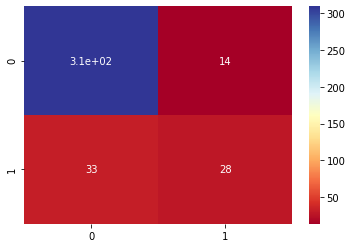

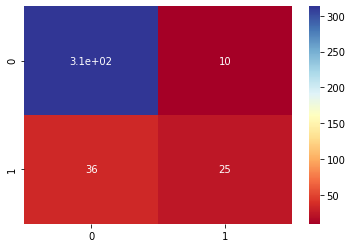

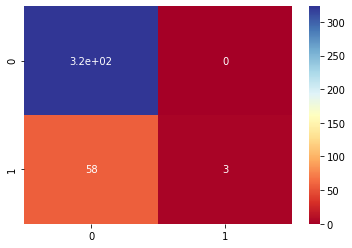

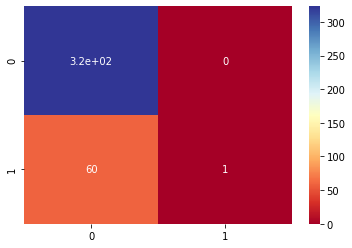

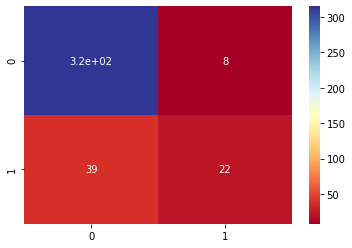

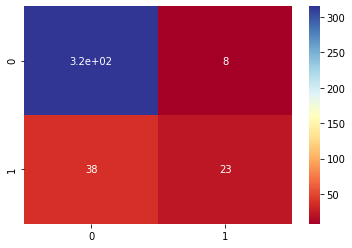

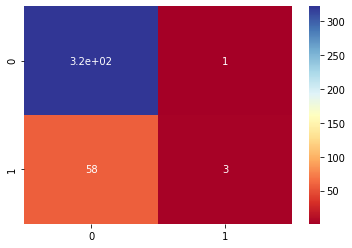

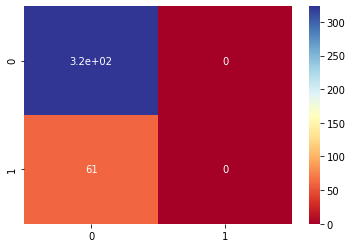

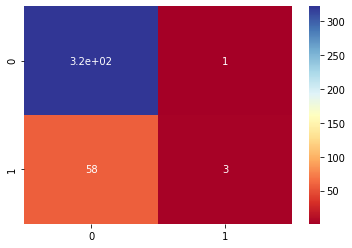

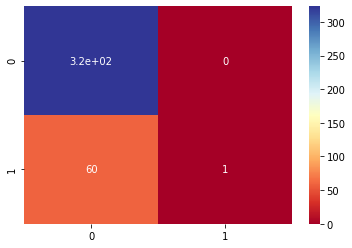

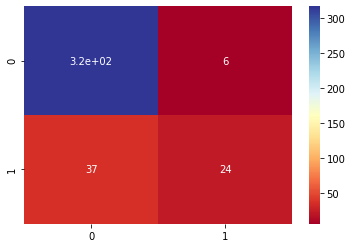

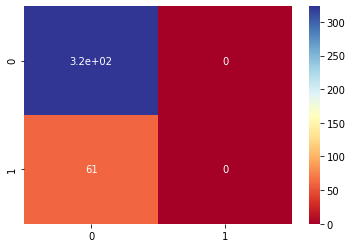

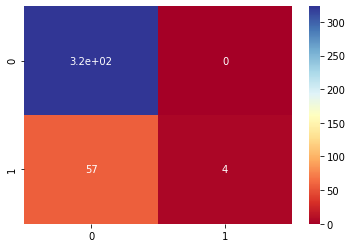

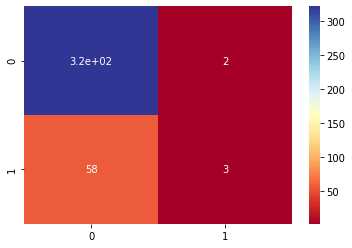

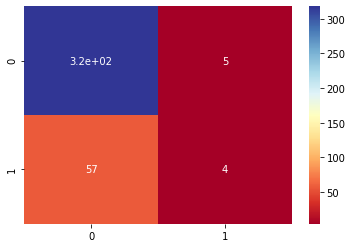

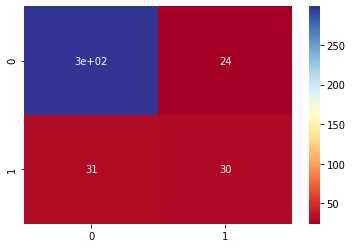

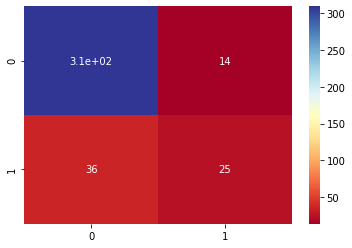

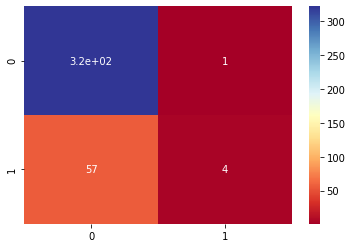

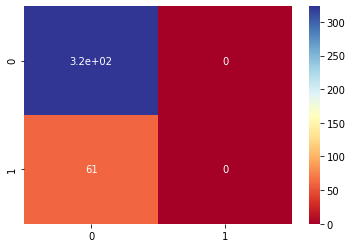

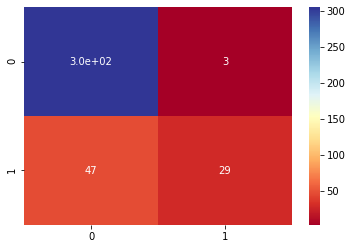

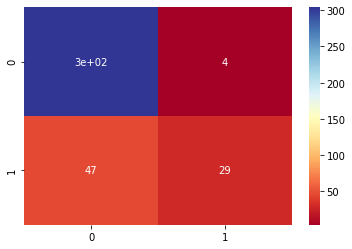

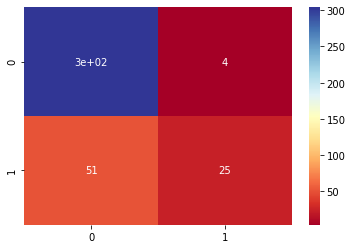

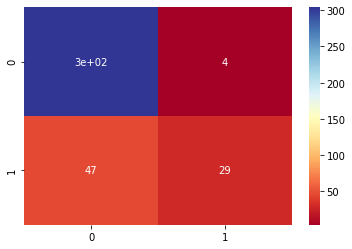

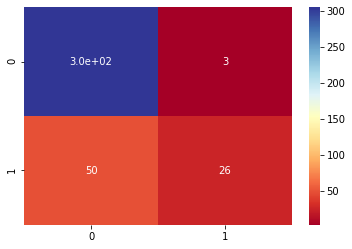

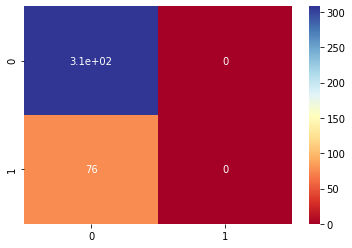

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
for iii in range(5):
  test_features= DATA[iii]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[iii]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[iii]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[iii]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  TEST_2input  = DoubleInputGenerator_VGG(test_features,test_imgs,test_labels,batch_size=48,target_size=(224,224))
  TEST_3input  = TripleInputGenerator_VGG(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(224,224))
  for (dirpath, dirnames, filenames) in walk(models[iii]):
    for files in filenames:
      if files.find('2inputs') != -1:
        print('Model Name = ', files)
        best_model = tf.keras.models.load_model(dirpath + '/' + files)
        y_pred = best_model.predict(TEST_2input)
        plt.figure()
        print(metrics.classification_report(test_labels[:len(y_score)], y_pred>0.5))
        sns.heatmap(metrics.confusion_matrix(test_labels[:len(y_score)], y_pred>0.5), cmap ="RdYlBu", annot = True) 
      if files.find('3inputs') != -1:
        print('Model Name = ', files)
        best_model = tf.keras.models.load_model(dirpath + '/' + files)
        y_pred = best_model.predict(TEST_3input)
        plt.figure()
        print(metrics.classification_report(test_labels[:len(y_score)], y_pred>0.5))
        sns.heatmap(metrics.confusion_matrix(test_labels[:len(y_score)], y_pred>0.5), cmap ="RdYlBu", annot = True) 


In [ ]:
print('No corona patient in a Dataset = ',np.count_nonzero(DATA[1]['LABELS'] == 0))
print('No corona patient in a Dataset = ', np.count_nonzero(DATA[1]['LABELS'] == 1))
print('The division between training, testing and validation is 70%, 15%, 15%\nThese result were based on testing data')

No corona patient in a Dataset =  2327
No corona patient in a Dataset =  527
The division between training, testing and validation is 70%, 15%, 15%
These result were based on testing data


In [ ]:
!cp /content/drive/MyDrive/Safe\ City/COVID\ DETECTION\ USING\ COUGH/models_custom_v3/4/002--0.086--0.064--3inputs_custom.hdf5 /content/

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/002--0.086--0.064--3inputs_custom.hdf5')
model.input

[<KerasTensor: shape=(None, 120) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'input_3')>]

In [ ]:
image_path = '/content/custom_dataset/00039425-7f3a-42aa-ac13-834aaa2b6b92.png'
target_size=(64,64)

In [ ]:
f = features[1]
feat = f.reshape(1,120)
np.shape(feat)

In [ ]:
d = diagnoses[1]
diag = [1,d]
diag

In [ ]:
image = np.array(img)

In [ ]:
x = np.empty((1,64,64,3))
x[0,] = img

In [ ]:
np.shape(x)

In [ ]:
test_features= DATA[1]['MFCCS'][0]
test_imgs    = DATA[1]['MEL'][0]
test_extra   = DATA[1]['EXTRA'][0]
test_labels  = DATA[1]['LABELS'][0]

In [ ]:
TEST_3input  = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=1,target_size=(64,64))

(64, 64)

In [ ]:
y_preds = model.predict(TEST_3input)

IndexError: ignored

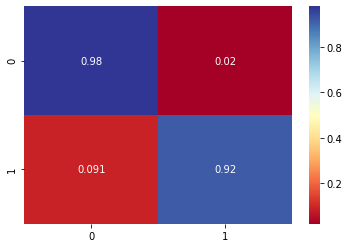

In [ ]:
import seaborn as sns
cnf_matrix = [[, 6/306],[7/77, 71/77]]
sns.heatmap(cnf_matrix, cmap ="RdYlBu", annot = True) 